In [1]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging

import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

2024-04-01 17:21:52.136685: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 17:21:52.140628: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 17:21:52.394323: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 17:21:52.930456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 17:21:54.315032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
path = os.getcwd()
path

'/home/rahuliyer/code/hramzan01/market/notebooks'

In [3]:
new_path = path.replace('notebooks', '')
new_path

'/home/rahuliyer/code/hramzan01/market/'

In [4]:
file = 'historic_demand_2009_2024_noNaN.csv'
raw_data = os.path.join(new_path, 'raw_data', file)
raw_data

'/home/rahuliyer/code/hramzan01/market/raw_data/historic_demand_2009_2024_noNaN.csv'

In [5]:
df = pd.read_csv(raw_data, index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

In [6]:
df.tail()

settlement_period period_hour     nd    tsd  \
settlement_date                                                    
2024-03-07 21:30:00                 44    21:30:00  30950  31827   
2024-03-07 22:00:00                 45    22:00:00  28691  29417   
2024-03-07 22:30:00                 46    22:30:00  26993  27720   
2024-03-07 23:00:00                 47    23:00:00  25420  26322   
2024-03-07 23:30:00                 48    23:30:00  24359  25502   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2024-03-07 21:30:00                 28651                      2603   
2024-03-07 22:00:00                 26616                      2575   
2024-03-07 22:30:00                 25041                      2547   
2024-03-07 23:00:00                 23495                      2580   
2024-03-07 23:30:00                 22496                      2613   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2024-03-07 21:30:00                    6562                          0   
2024-03-07 22:00:00                    6562                          0   
2024-03-07 22:30:00                    6562                          0   
2024-03-07 23:00:00                    6562                          0   
2024-03-07 23:30:00                    6562                          0   

                     embedded_solar_capacity  non_bm_stor  \
settlement_date                                             
2024-03-07 21:30:00                    15905            0   
2024-03-07 22:00:00                    15905            0   
2024-03-07 22:30:00                    15905            0   
2024-03-07 23:00:00                    15905            0   
2024-03-07 23:30:00                    15905            0   

                     pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  \
settlement_date                                                                
2024-03-07 21:30:00                     3      1591        822          1004   
2024-03-07 22:00:00                     3      1299        562           761   
2024-03-07 22:30:00                     6      1277        541           737   
2024-03-07 23:00:00                    15      1550        767           393   
2024-03-07 23:30:00                   283      1573        787           385   

                     moyle_flow  east_west_flow  nemo_flow  is_holiday  
settlement_date                                                         
2024-03-07 21:30:00        -170            -104        761           0  
2024-03-07 22:00:00        -122              -1        544           0  
2024-03-07 22:30:00        -121               0        528           0  
2024-03-07 23:00:00        -170               0        236           0  
2024-03-07 23:30:00         -88               0        214           0

In [7]:
df.describe()

settlement_period             nd            tsd  england_wales_demand  \
count      265410.000000  265410.000000  265410.000000         265410.000000   
mean           24.497400   31497.308346   32975.015681          28662.954075   
std            13.852049    7808.144316    7588.161036           7075.540769   
min             1.000000   13367.000000   16513.000000              0.000000   
25%            12.000000   25247.000000   26928.000000          22978.000000   
50%            24.000000   30884.000000   32143.000000          28099.000000   
75%            36.000000   37225.000000   38409.000000          33895.000000   
max            48.000000   59095.000000   60147.000000          53325.000000   

       embedded_wind_generation  embedded_wind_capacity  \
count             265410.000000           265410.000000   
mean                1248.271018             4348.665363   
std                  950.745433             1943.790413   
min                    0.000000             1403.000000   
25%                  540.000000             2092.000000   
50%                  999.000000             4276.000000   
75%                 1696.000000             6488.000000   
max                 5587.000000             6574.000000   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              265410.000000            265410.000000  265410.000000   
mean                  831.494371              8278.371301       6.997604   
std                  1639.094063              5683.254567      40.124803   
min                     0.000000                 0.000000     -24.000000   
25%                     0.000000              1970.000000       0.000000   
50%                     0.000000             11100.000000       0.000000   
75%                   802.000000             13080.000000       0.000000   
max                  9830.000000             15954.000000     893.000000   

       pump_storage_pumping       ifa_flow      ifa2_flow   britned_flow  \
count         265410.000000  265410.000000  265410.000000  265410.000000   
mean             311.222234     912.611168      28.754904     522.307125   
std              536.074687    1084.753556     327.742836     526.470603   
min                0.000000   -2056.000000   -1030.000000   -1215.000000   
25%                8.000000     206.000000       0.000000       0.000000   
50%               11.000000    1197.000000       0.000000     749.000000   
75%              396.000000    1895.000000       0.000000     994.000000   
max             2019.000000    2066.000000    1016.000000    1143.000000   

          moyle_flow  east_west_flow      nemo_flow     is_holiday  
count  265410.000000   265410.000000  265410.000000  265410.000000  
mean     -116.443032      -37.262624     160.700441       0.022607  
std       227.833340      256.476658     405.428489       0.148646  
min      -505.000000     -585.000000   -1022.000000       0.000000  
25%      -274.000000     -168.000000       0.000000       0.000000  
50%      -134.000000        0.000000       0.000000       0.000000  
75%        37.000000        0.000000     100.000000       0.000000  
max       499.000000      504.000000    1033.000000       1.000000

In [8]:
df.shape

(265410, 18)

In [9]:
df.isna().any()

settlement_period            False
period_hour                  False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
is_holiday                   False
dtype: bool

In [10]:
import holidays

In [11]:
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2025), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2025), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [12]:
bank_holiday_england

dict_items([(datetime.date(2016, 3, 25), 'Good Friday'), (datetime.date(2016, 5, 2), 'May Day'), (datetime.date(2016, 5, 30), 'Spring Bank Holiday'), (datetime.date(2016, 3, 28), 'Easter Monday'), (datetime.date(2016, 8, 29), 'Late Summer Bank Holiday'), (datetime.date(2016, 1, 1), "New Year's Day"), (datetime.date(2016, 12, 25), 'Christmas Day'), (datetime.date(2016, 12, 27), 'Christmas Day (observed)'), (datetime.date(2016, 12, 26), 'Boxing Day'), (datetime.date(2017, 4, 14), 'Good Friday'), (datetime.date(2017, 5, 1), 'May Day'), (datetime.date(2017, 5, 29), 'Spring Bank Holiday'), (datetime.date(2017, 4, 17), 'Easter Monday'), (datetime.date(2017, 8, 28), 'Late Summer Bank Holiday'), (datetime.date(2017, 1, 1), "New Year's Day"), (datetime.date(2017, 1, 2), "New Year's Day (observed)"), (datetime.date(2017, 12, 25), 'Christmas Day'), (datetime.date(2017, 12, 26), 'Boxing Day'), (datetime.date(2018, 3, 30), 'Good Friday'), (datetime.date(2018, 5, 7), 'May Day'), (datetime.date(2018,

In [13]:
df_holidays = pd.DataFrame.from_dict(bank_holiday_england)
df_holidays.columns = ['date', 'holiday']
df_holidays.head()

date                   holiday
0  2016-03-25               Good Friday
1  2016-05-02                   May Day
2  2016-05-30       Spring Bank Holiday
3  2016-03-28             Easter Monday
4  2016-08-29  Late Summer Bank Holiday

In [14]:
df_holidays.sort_values(by='date', ascending=True)

date                   holiday
88  2009-01-01            New Year's Day
83  2009-04-10               Good Friday
86  2009-04-13             Easter Monday
84  2009-05-04                   May Day
85  2009-05-25       Spring Bank Holiday
..         ...                       ...
76  2024-05-06                   May Day
77  2024-05-27       Spring Bank Holiday
79  2024-08-26  Late Summer Bank Holiday
81  2024-12-25             Christmas Day
82  2024-12-26                Boxing Day

[148 rows x 2 columns]

In [15]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[-5:], len(holiday_dates_observed)

([numpy.datetime64('2024-05-06'),
  numpy.datetime64('2024-05-27'),
  numpy.datetime64('2024-08-26'),
  numpy.datetime64('2024-12-25'),
  numpy.datetime64('2024-12-26')],
 133)

In [16]:
holiday_names_observed[-5:], len(holiday_names_observed)

(['May Day',
  'Spring Bank Holiday',
  'Late Summer Bank Holiday',
  'Christmas Day',
  'Boxing Day'],
 133)

In [17]:
df.index

Index(['2009-01-01 00:00:00', '2009-01-01 00:30:00', '2009-01-01 01:00:00',
       '2009-01-01 01:30:00', '2009-01-01 02:00:00', '2009-01-01 02:30:00',
       '2009-01-01 03:00:00', '2009-01-01 03:30:00', '2009-01-01 04:00:00',
       '2009-01-01 04:30:00',
       ...
       '2024-03-07 19:00:00', '2024-03-07 19:30:00', '2024-03-07 20:00:00',
       '2024-03-07 20:30:00', '2024-03-07 21:00:00', '2024-03-07 21:30:00',
       '2024-03-07 22:00:00', '2024-03-07 22:30:00', '2024-03-07 23:00:00',
       '2024-03-07 23:30:00'],
      dtype='object', name='settlement_date', length=265410)

In [18]:
df.index = pd.to_datetime(df.index)
df['date'] = df.index.date

df["is_holiday"] = df["date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df["is_holiday"] = df["is_holiday"].astype(int)

# df["is_holiday"] = df.index.isin(holiday_dates_observed).astype(int)

In [19]:
# df["is_holiday"] = df["is_holiday"].astype(int)

# df[df["is_holiday"] == 1].sample(7)

df.head()

settlement_period period_hour     nd    tsd  \
settlement_date                                                    
2009-01-01 00:00:00                  1     0:00:00  37910  38704   
2009-01-01 00:30:00                  2     0:30:00  38047  38964   
2009-01-01 01:00:00                  3     1:00:00  37380  38651   
2009-01-01 01:30:00                  4     1:30:00  36426  37775   
2009-01-01 02:00:00                  5     2:00:00  35687  37298   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2009-01-01 00:00:00                 33939                        54   
2009-01-01 00:30:00                 34072                        53   
2009-01-01 01:00:00                 33615                        53   
2009-01-01 01:30:00                 32526                        50   
2009-01-01 02:00:00                 31877                        50   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2009-01-01 00:00:00                    1403                          0   
2009-01-01 00:30:00                    1403                          0   
2009-01-01 01:00:00                    1403                          0   
2009-01-01 01:30:00                    1403                          0   
2009-01-01 02:00:00                    1403                          0   

                     embedded_solar_capacity  non_bm_stor  \
settlement_date                                             
2009-01-01 00:00:00                        0            0   
2009-01-01 00:30:00                        0            0   
2009-01-01 01:00:00                        0            0   
2009-01-01 01:30:00                        0            0   
2009-01-01 02:00:00                        0            0   

                     pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  \
settlement_date                                                                
2009-01-01 00:00:00                    33      2002          0             0   
2009-01-01 00:30:00                   157      2002          0             0   
2009-01-01 01:00:00                   511      2002          0             0   
2009-01-01 01:30:00                   589      1772          0             0   
2009-01-01 02:00:00                   851      1753          0             0   

                     moyle_flow  east_west_flow  nemo_flow  is_holiday  \
settlement_date                                                          
2009-01-01 00:00:00        -161               0          0           1   
2009-01-01 00:30:00        -160               0          0           1   
2009-01-01 01:00:00        -160               0          0           1   
2009-01-01 01:30:00        -160               0          0           1   
2009-01-01 02:00:00        -160               0          0           1   

                           date  
settlement_date                  
2009-01-01 00:00:00  2009-01-01  
2009-01-01 00:30:00  2009-01-01  
2009-01-01 01:00:00  2009-01-01  
2009-01-01 01:30:00  2009-01-01  
2009-01-01 02:00:00  2009-01-01

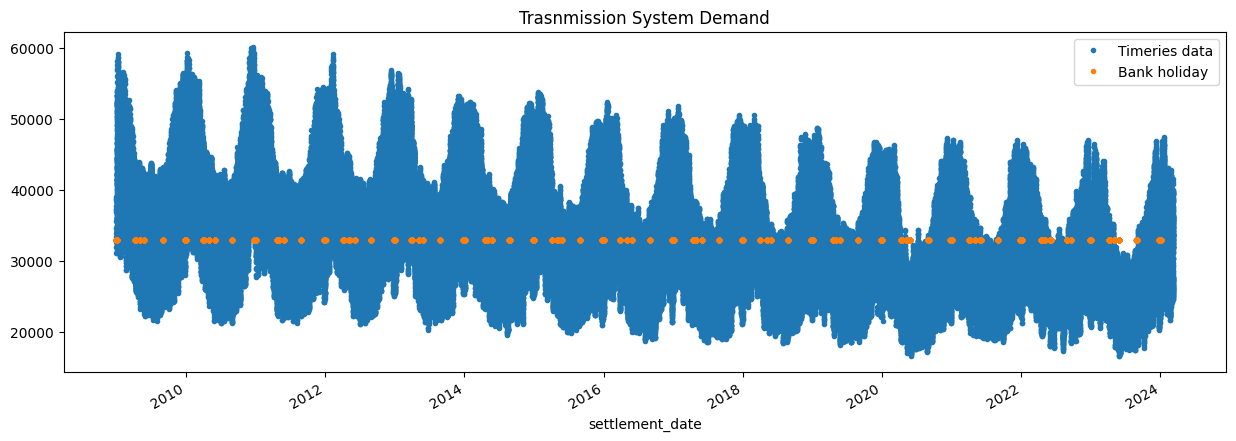

In [20]:
df_plot = df.copy()

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

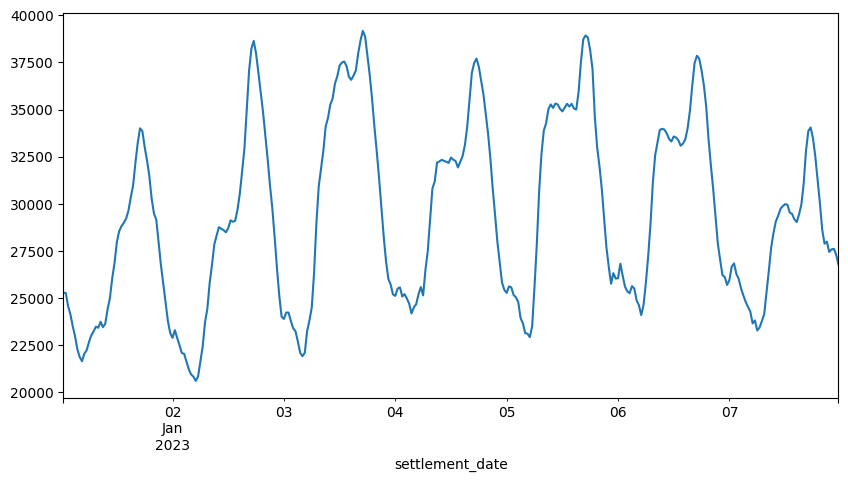

In [21]:
df_plot.loc[(df_plot.index > "01-01-2023") & (df_plot.index < "01-08-2023")][
    "tsd"
].plot(figsize=(10, 5));


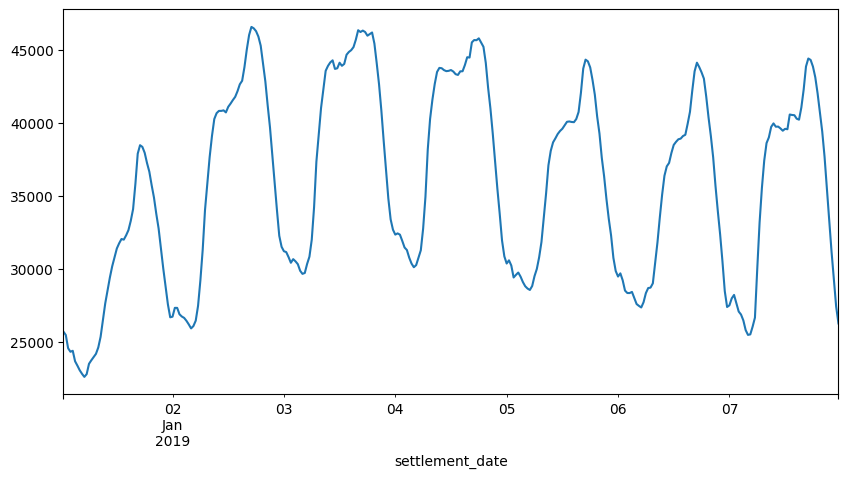

In [22]:
df_plot.loc[(df_plot.index > "01-01-2019") & (df_plot.index < "01-08-2019")][
    "tsd"
].plot(figsize=(10, 5));

In [23]:
df_plot.head()

settlement_period period_hour     nd    tsd  \
settlement_date                                                    
2009-01-01 00:00:00                  1     0:00:00  37910  38704   
2009-01-01 00:30:00                  2     0:30:00  38047  38964   
2009-01-01 01:00:00                  3     1:00:00  37380  38651   
2009-01-01 01:30:00                  4     1:30:00  36426  37775   
2009-01-01 02:00:00                  5     2:00:00  35687  37298   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2009-01-01 00:00:00                 33939                        54   
2009-01-01 00:30:00                 34072                        53   
2009-01-01 01:00:00                 33615                        53   
2009-01-01 01:30:00                 32526                        50   
2009-01-01 02:00:00                 31877                        50   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2009-01-01 00:00:00                    1403                          0   
2009-01-01 00:30:00                    1403                          0   
2009-01-01 01:00:00                    1403                          0   
2009-01-01 01:30:00                    1403                          0   
2009-01-01 02:00:00                    1403                          0   

                     embedded_solar_capacity  non_bm_stor  \
settlement_date                                             
2009-01-01 00:00:00                        0            0   
2009-01-01 00:30:00                        0            0   
2009-01-01 01:00:00                        0            0   
2009-01-01 01:30:00                        0            0   
2009-01-01 02:00:00                        0            0   

                     pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  \
settlement_date                                                                
2009-01-01 00:00:00                    33      2002          0             0   
2009-01-01 00:30:00                   157      2002          0             0   
2009-01-01 01:00:00                   511      2002          0             0   
2009-01-01 01:30:00                   589      1772          0             0   
2009-01-01 02:00:00                   851      1753          0             0   

                     moyle_flow  east_west_flow  nemo_flow  is_holiday  \
settlement_date                                                          
2009-01-01 00:00:00        -161               0          0           1   
2009-01-01 00:30:00        -160               0          0           1   
2009-01-01 01:00:00        -160               0          0           1   
2009-01-01 01:30:00        -160               0          0           1   
2009-01-01 02:00:00        -160               0          0           1   

                           date  
settlement_date                  
2009-01-01 00:00:00  2009-01-01  
2009-01-01 00:30:00  2009-01-01  
2009-01-01 01:00:00  2009-01-01  
2009-01-01 01:30:00  2009-01-01  
2009-01-01 02:00:00  2009-01-01

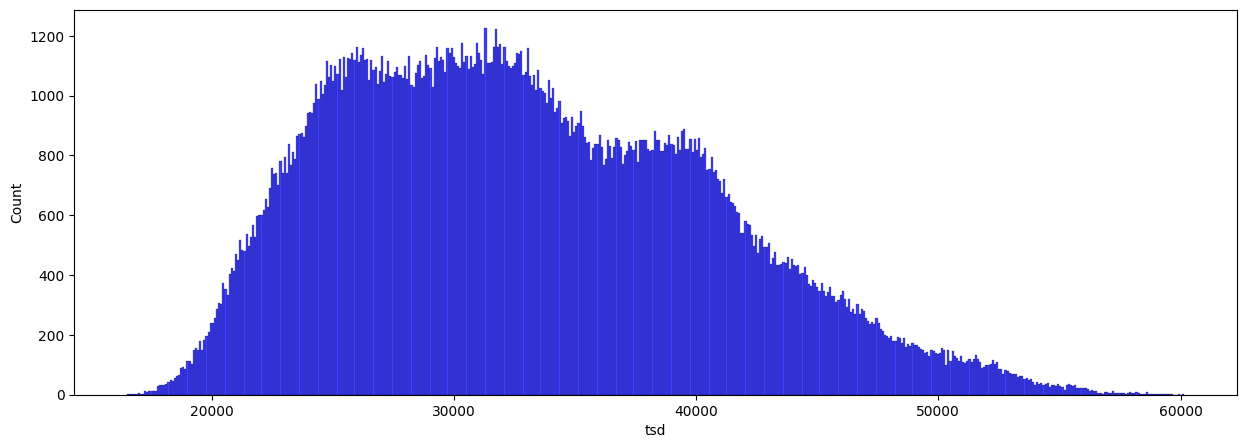

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

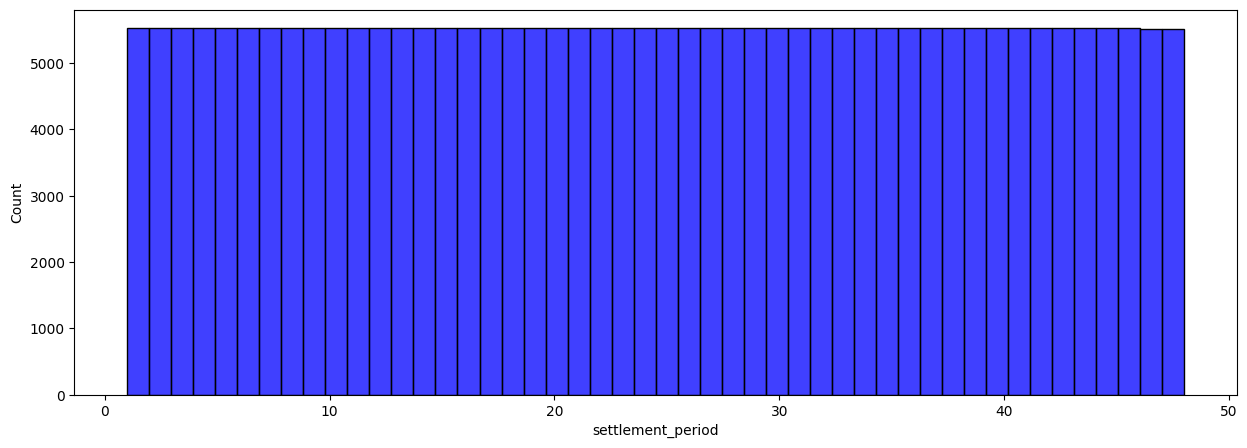

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=df, x="settlement_period", bins=48, ax=ax, color="b");

In [26]:
value_counts = df['settlement_period'].value_counts()

# Example: Get the count of 'A' in the column
count_of = value_counts[40]
count_of/365

15.150684931506849

In [27]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df

def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [28]:
df = create_features(df)
df = add_lags(df)
df.head()

settlement_period period_hour     nd    tsd  \
settlement_date                                                    
2009-01-01 00:00:00                  1     0:00:00  37910  38704   
2009-01-01 00:30:00                  2     0:30:00  38047  38964   
2009-01-01 01:00:00                  3     1:00:00  37380  38651   
2009-01-01 01:30:00                  4     1:30:00  36426  37775   
2009-01-01 02:00:00                  5     2:00:00  35687  37298   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2009-01-01 00:00:00                 33939                        54   
2009-01-01 00:30:00                 34072                        53   
2009-01-01 01:00:00                 33615                        53   
2009-01-01 01:30:00                 32526                        50   
2009-01-01 02:00:00                 31877                        50   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2009-01-01 00:00:00                    1403                          0   
2009-01-01 00:30:00                    1403                          0   
2009-01-01 01:00:00                    1403                          0   
2009-01-01 01:30:00                    1403                          0   
2009-01-01 02:00:00                    1403                          0   

                     embedded_solar_capacity  non_bm_stor  ...  day_of_month  \
settlement_date                                            ...                 
2009-01-01 00:00:00                        0            0  ...             1   
2009-01-01 00:30:00                        0            0  ...             1   
2009-01-01 01:00:00                        0            0  ...             1   
2009-01-01 01:30:00                        0            0  ...             1   
2009-01-01 02:00:00                        0            0  ...             1   

                     day_of_week  day_of_year  quarter  month  year  \
settlement_date                                                       
2009-01-01 00:00:00            3            1        1      1  2009   
2009-01-01 00:30:00            3            1        1      1  2009   
2009-01-01 01:00:00            3            1        1      1  2009   
2009-01-01 01:30:00            3            1        1      1  2009   
2009-01-01 02:00:00            3            1        1      1  2009   

                     week_of_year  lag1 lag2  lag3  
settlement_date                                     
2009-01-01 00:00:00             1   NaN  NaN   NaN  
2009-01-01 00:30:00             1   NaN  NaN   NaN  
2009-01-01 01:00:00             1   NaN  NaN   NaN  
2009-01-01 01:30:00             1   NaN  NaN   NaN  
2009-01-01 02:00:00             1   NaN  NaN   NaN  

[5 rows x 29 columns]

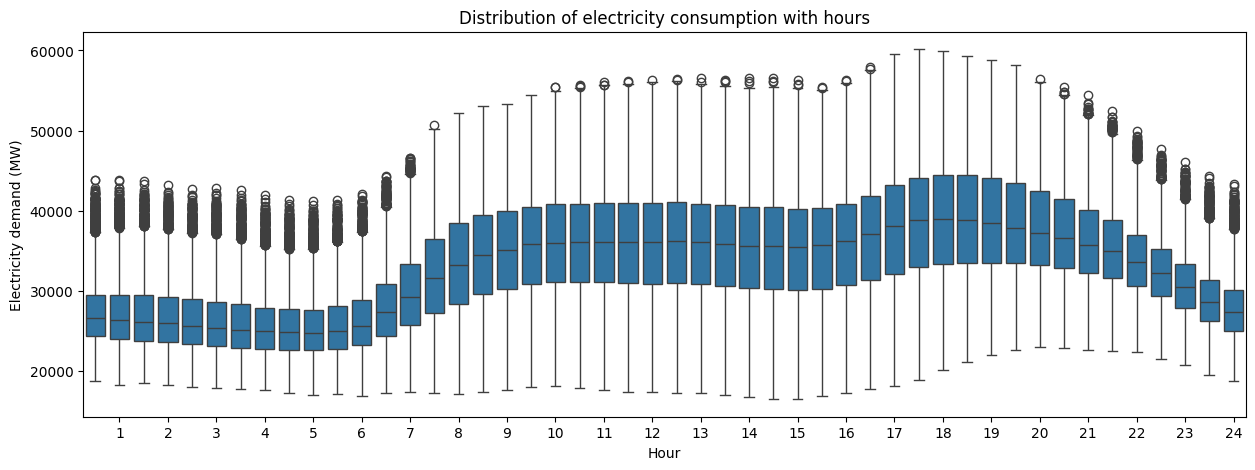

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

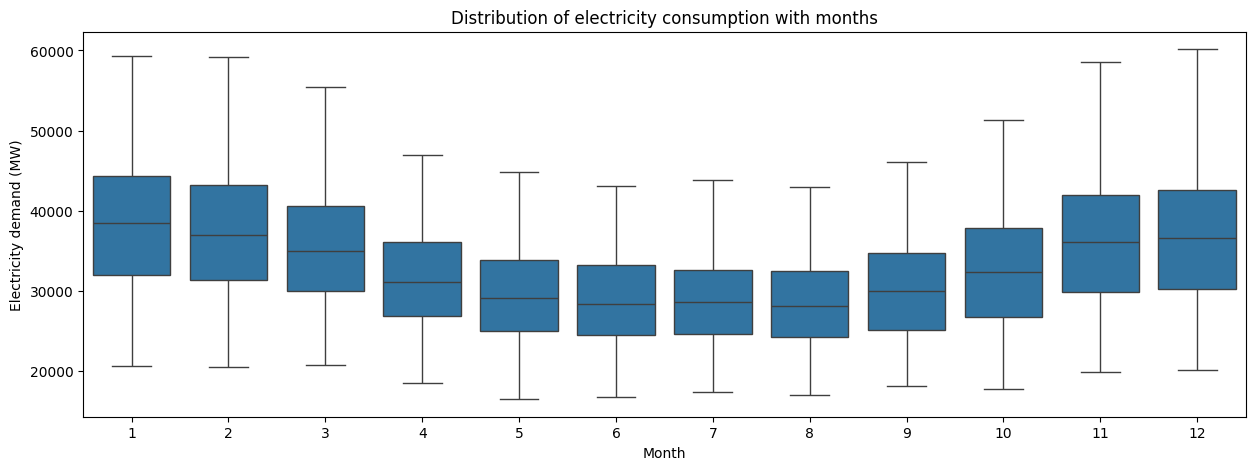

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

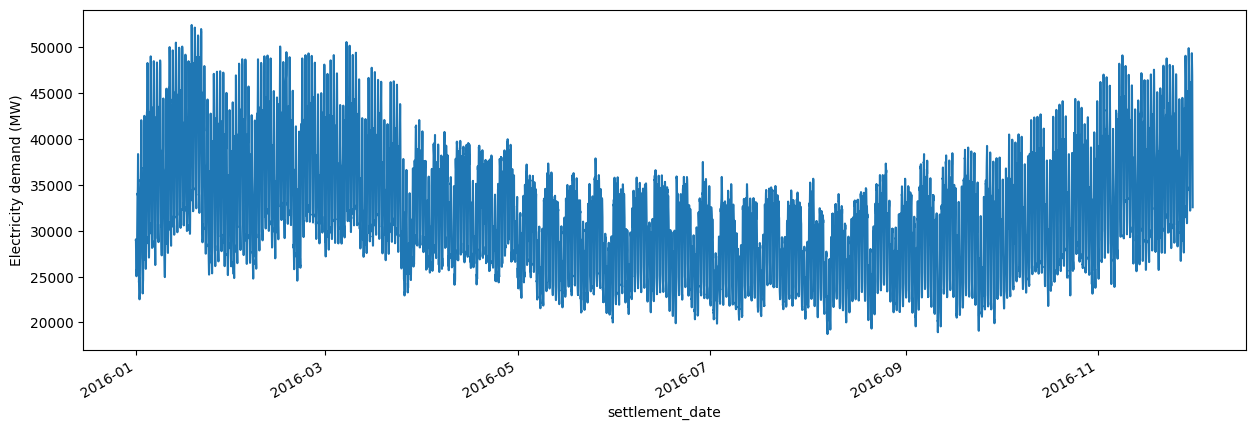

In [31]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

/tmp/ipykernel_3082/1200840721.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


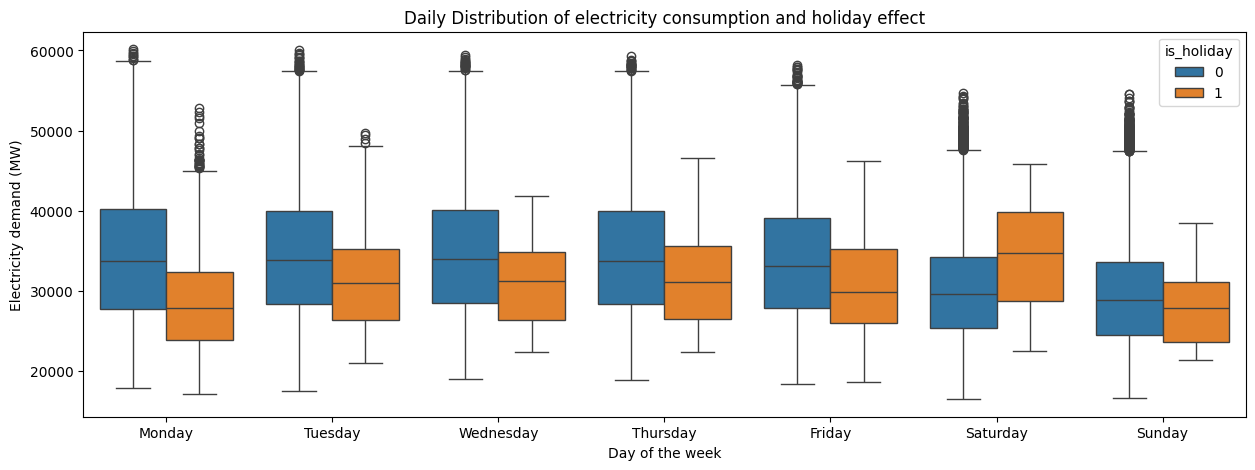

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

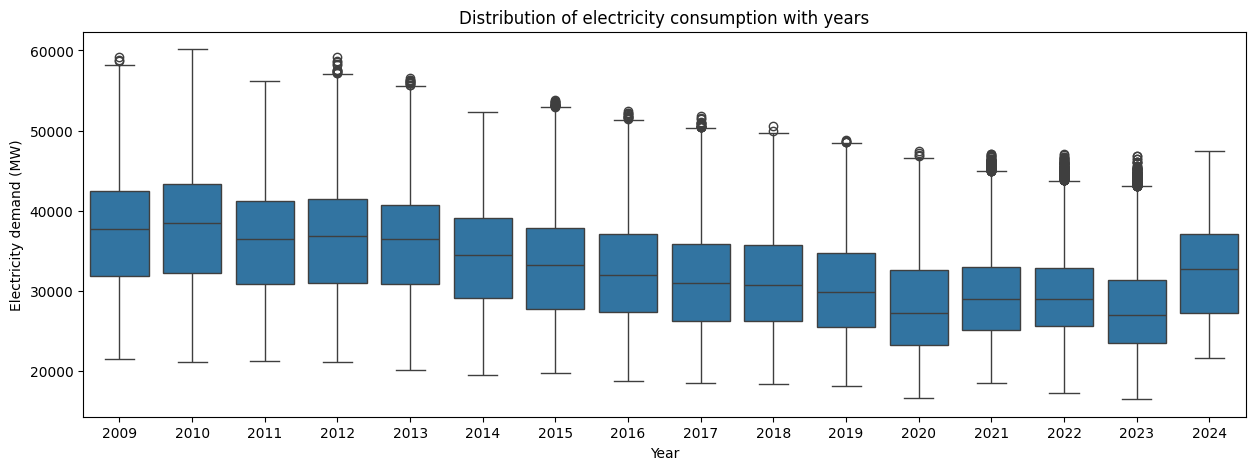

In [33]:

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

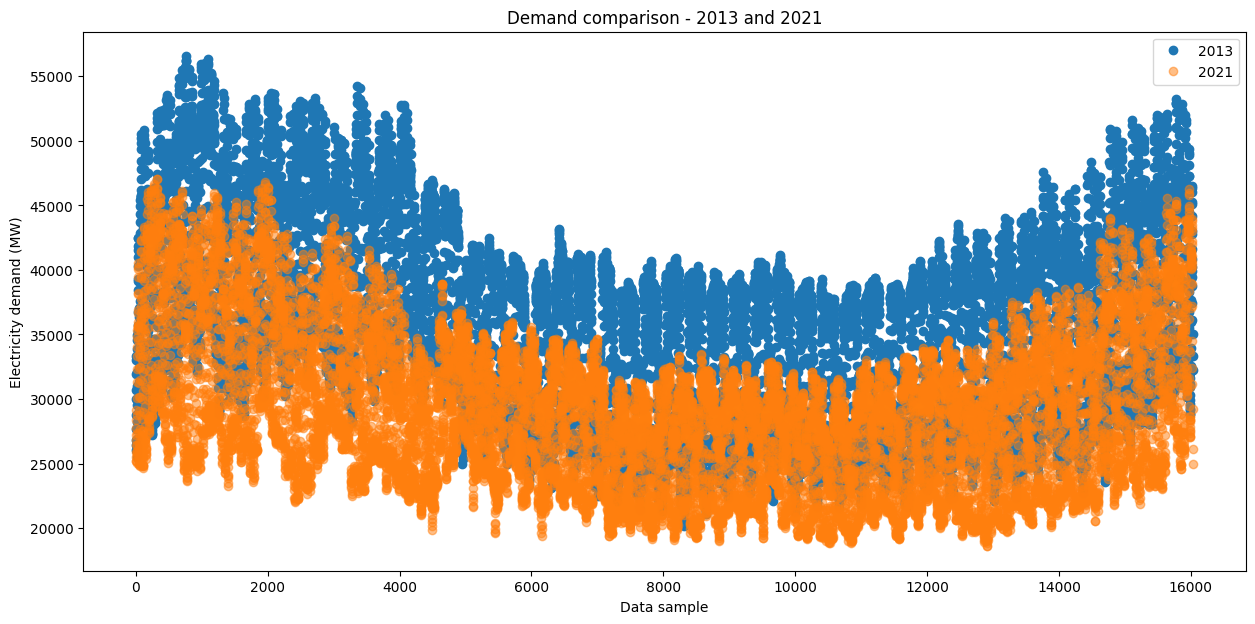

In [34]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

In [35]:
df['settlement_date'] = df.index


In [36]:
df.head()

settlement_period period_hour     nd    tsd  \
settlement_date                                                    
2009-01-01 00:00:00                  1     0:00:00  37910  38704   
2009-01-01 00:30:00                  2     0:30:00  38047  38964   
2009-01-01 01:00:00                  3     1:00:00  37380  38651   
2009-01-01 01:30:00                  4     1:30:00  36426  37775   
2009-01-01 02:00:00                  5     2:00:00  35687  37298   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2009-01-01 00:00:00                 33939                        54   
2009-01-01 00:30:00                 34072                        53   
2009-01-01 01:00:00                 33615                        53   
2009-01-01 01:30:00                 32526                        50   
2009-01-01 02:00:00                 31877                        50   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2009-01-01 00:00:00                    1403                          0   
2009-01-01 00:30:00                    1403                          0   
2009-01-01 01:00:00                    1403                          0   
2009-01-01 01:30:00                    1403                          0   
2009-01-01 02:00:00                    1403                          0   

                     embedded_solar_capacity  non_bm_stor  ...  day_of_week  \
settlement_date                                            ...                
2009-01-01 00:00:00                        0            0  ...            3   
2009-01-01 00:30:00                        0            0  ...            3   
2009-01-01 01:00:00                        0            0  ...            3   
2009-01-01 01:30:00                        0            0  ...            3   
2009-01-01 02:00:00                        0            0  ...            3   

                     day_of_year  quarter  month  year  week_of_year  lag1  \
settlement_date                                                              
2009-01-01 00:00:00            1        1      1  2009             1   NaN   
2009-01-01 00:30:00            1        1      1  2009             1   NaN   
2009-01-01 01:00:00            1        1      1  2009             1   NaN   
2009-01-01 01:30:00            1        1      1  2009             1   NaN   
2009-01-01 02:00:00            1        1      1  2009             1   NaN   

                     lag2 lag3     settlement_date  
settlement_date                                     
2009-01-01 00:00:00   NaN  NaN 2009-01-01 00:00:00  
2009-01-01 00:30:00   NaN  NaN 2009-01-01 00:30:00  
2009-01-01 01:00:00   NaN  NaN 2009-01-01 01:00:00  
2009-01-01 01:30:00   NaN  NaN 2009-01-01 01:30:00  
2009-01-01 02:00:00   NaN  NaN 2009-01-01 02:00:00  

[5 rows x 30 columns]

In [37]:
df.describe()
# null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

# null_days

settlement_period             nd            tsd  england_wales_demand  \
count      265410.000000  265410.000000  265410.000000         265410.000000   
mean           24.497400   31497.308346   32975.015681          28662.954075   
std            13.852049    7808.144316    7588.161036           7075.540769   
min             1.000000   13367.000000   16513.000000              0.000000   
25%            12.000000   25247.000000   26928.000000          22978.000000   
50%            24.000000   30884.000000   32143.000000          28099.000000   
75%            36.000000   37225.000000   38409.000000          33895.000000   
max            48.000000   59095.000000   60147.000000          53325.000000   

       embedded_wind_generation  embedded_wind_capacity  \
count             265410.000000           265410.000000   
mean                1248.271018             4348.665363   
std                  950.745433             1943.790413   
min                    0.000000             1403.000000   
25%                  540.000000             2092.000000   
50%                  999.000000             4276.000000   
75%                 1696.000000             6488.000000   
max                 5587.000000             6574.000000   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              265410.000000            265410.000000  265410.000000   
mean                  831.494371              8278.371301       6.997604   
std                  1639.094063              5683.254567      40.124803   
min                     0.000000                 0.000000     -24.000000   
25%                     0.000000              1970.000000       0.000000   
50%                     0.000000             11100.000000       0.000000   
75%                   802.000000             13080.000000       0.000000   
max                  9830.000000             15954.000000     893.000000   

       pump_storage_pumping  ...   day_of_month    day_of_week    day_of_year  \
count         265410.000000  ...  265410.000000  265410.000000  265410.000000   
mean             311.222234  ...      15.710380       2.998757     181.299258   
std              536.074687  ...       8.795568       1.999274     106.189125   
min                0.000000  ...       1.000000       0.000000       1.000000   
25%                8.000000  ...       8.000000       1.000000      88.000000   
50%               11.000000  ...      16.000000       3.000000     181.000000   
75%              396.000000  ...      23.000000       5.000000     273.000000   
max             2019.000000  ...      31.000000       6.000000     366.000000   

             quarter          month          year   week_of_year  \
count  265410.000000  265410.000000  265410.00000  265410.000000   
mean        2.490584       6.464587    2016.11032      26.358720   
std         1.123433       3.473686       4.37954      15.170558   
min         1.000000       1.000000    2009.00000       1.000000   
25%         1.000000       3.000000    2012.00000      13.000000   
50%         2.000000       6.000000    2016.00000      26.000000   
75%         3.000000       9.000000    2020.00000      40.000000   
max         4.000000      12.000000    2024.00000      53.000000   

                lag1           lag2           lag3  
count  247312.000000  230030.000000  212556.000000  
mean    33329.298028   33616.200817   33954.980833  
std      7578.656781    7654.662311    7688.754473  
min     16629.000000   16629.000000   16629.000000  
25%     27317.000000   27549.000000   27853.000000  
50%     32540.000000   32908.000000   33324.000000  
75%     38762.000000   39135.000000   39475.000000  
max     60147.000000   60147.000000   60147.000000  

[8 rows x 27 columns]

In [38]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

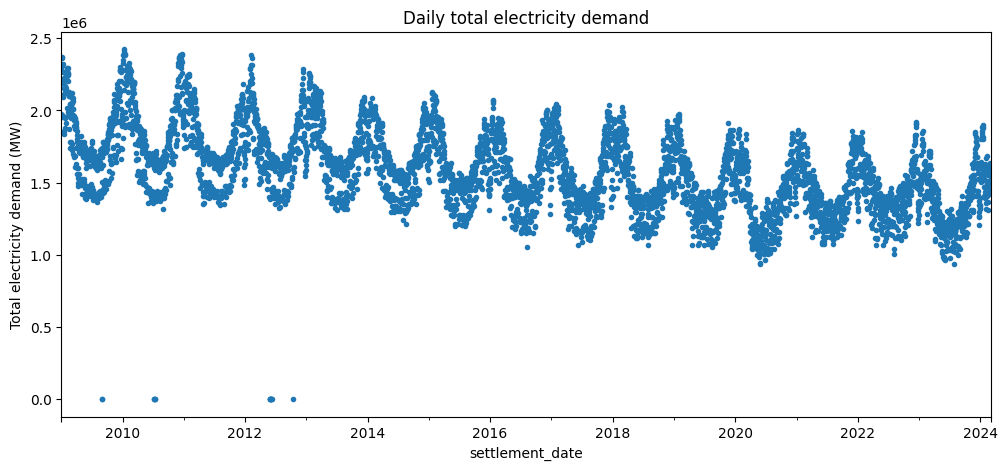

In [39]:
df_sarima = df["tsd"].resample("D").sum().to_frame()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year
df_sarima["settlement_date"] = df_sarima.index

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

In [40]:
df_sarima.head()

tsd  month  year settlement_date
settlement_date                                      
2009-01-01       1849363      1  2009      2009-01-01
2009-01-02       1974406      1  2009      2009-01-02
2009-01-03       1952054      1  2009      2009-01-03
2009-01-04       1968670      1  2009      2009-01-04
2009-01-05       2271471      1  2009      2009-01-05

In [41]:
df_sarima[df_sarima['tsd']==0]

tsd  month  year settlement_date
settlement_date                                  
2009-08-29         0      8  2009      2009-08-29
2009-08-30         0      8  2009      2009-08-30
2010-07-09         0      7  2010      2010-07-09
2010-07-10         0      7  2010      2010-07-10
2010-07-13         0      7  2010      2010-07-13
2010-07-14         0      7  2010      2010-07-14
2012-05-29         0      5  2012      2012-05-29
2012-05-30         0      5  2012      2012-05-30
2012-05-31         0      5  2012      2012-05-31
2012-06-01         0      6  2012      2012-06-01
2012-06-02         0      6  2012      2012-06-02
2012-06-03         0      6  2012      2012-06-03
2012-06-04         0      6  2012      2012-06-04
2012-06-11         0      6  2012      2012-06-11
2012-10-14         0     10  2012      2012-10-14

In [42]:
null_days = df_sarima.loc[df_sarima["tsd"] == 0.0, "settlement_date"].tolist()

pd.DataFrame(null_days)

0
0  2009-08-29
1  2009-08-30
2  2010-07-09
3  2010-07-10
4  2010-07-13
5  2010-07-14
6  2012-05-29
7  2012-05-30
8  2012-05-31
9  2012-06-01
10 2012-06-02
11 2012-06-03
12 2012-06-04
13 2012-06-11
14 2012-10-14

In [43]:
null_info = zip(
    df_sarima.loc[null_days].index.month, df_sarima.loc[null_days].index.year
)

In [44]:
null_info

In [45]:
mean_values = [
    df_sarima.loc[
        (df_sarima["month"] == info[0]) & (df_sarima["year"] == info[1]), "tsd"
    ].mean()
    for info in null_info
]

df_sarima.loc[null_days, "tsd"] = mean_values

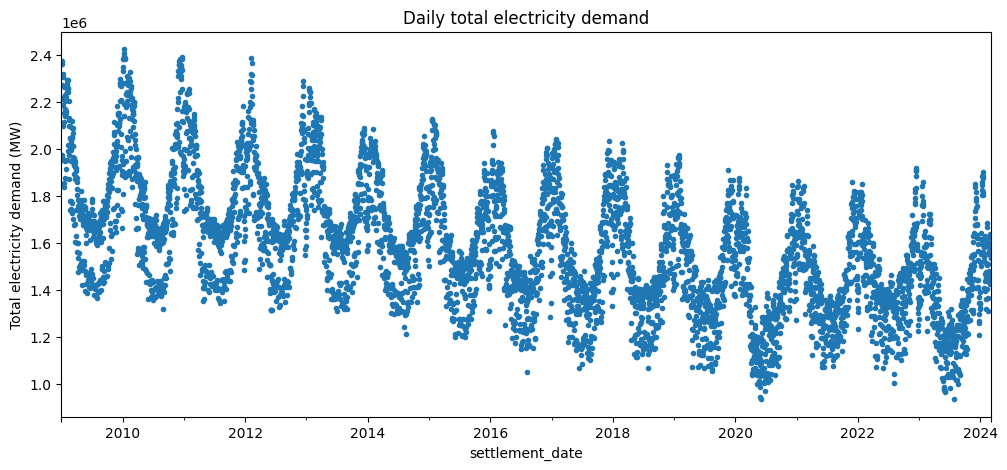

In [46]:
df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

In [47]:
df_sarima["lag_day"] = df_sarima["tsd"].shift(1)
df_sarima["lag_year"] = df_sarima["tsd"].shift(364)


df_sarima["difference_day"] = df_sarima["tsd"] - df_sarima["lag_day"]
df_sarima["difference_year"] = df_sarima["tsd"] - df_sarima["lag_year"]

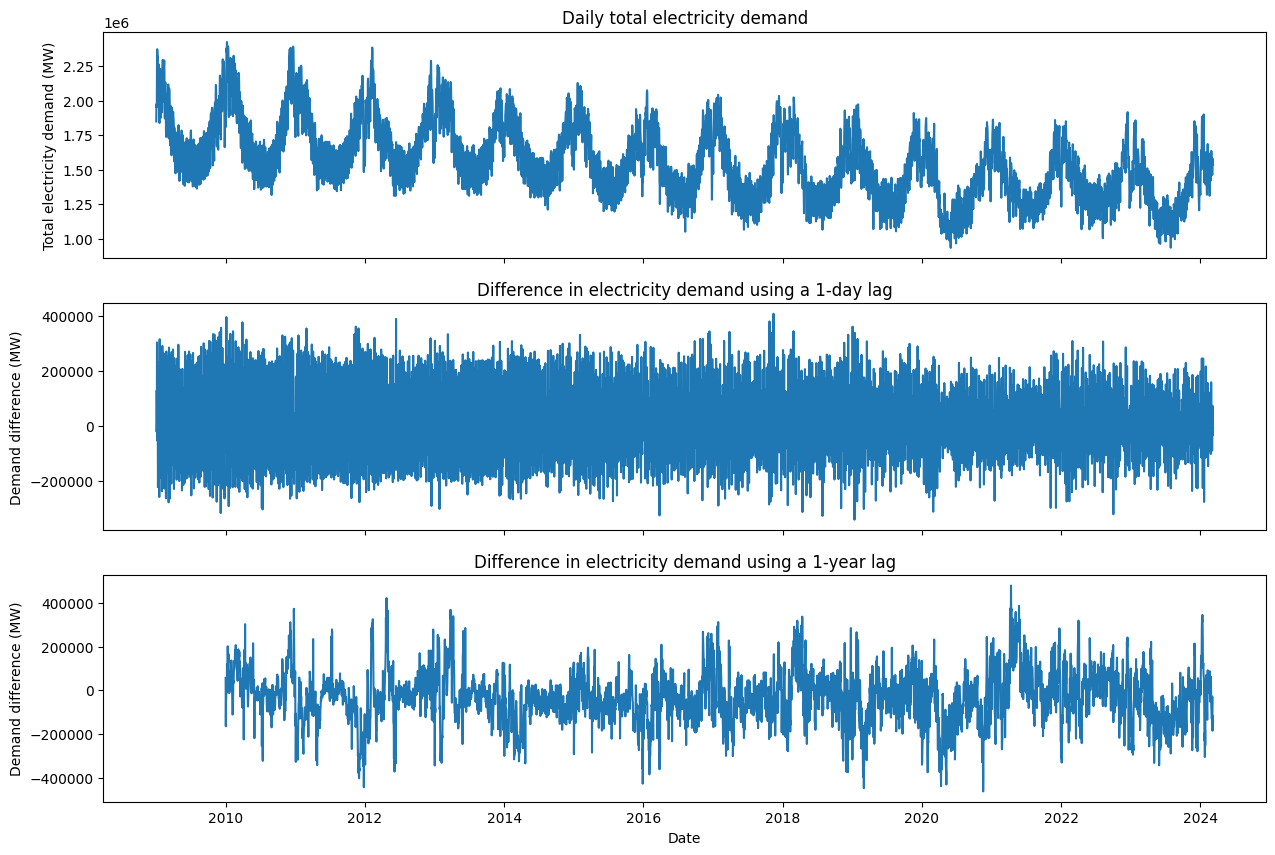

In [48]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes.ravel()
axes[0].plot(df_sarima.index, df_sarima["tsd"])
axes[0].set_ylabel("Total electricity demand (MW)")
axes[0].set_title("Daily total electricity demand")
axes[1].plot(df_sarima.index, df_sarima["difference_day"])
axes[1].set_ylabel("Demand difference (MW)")
axes[1].set_title("Difference in electricity demand using a 1-day lag")
axes[2].plot(df_sarima.index, df_sarima["difference_year"])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand difference (MW)")
axes[2].set_title("Difference in electricity demand using a 1-year lag");

In [50]:
def dftest(timeseries, window_size):
    """
    Perform ADFuller test, report the results and plot rolling statistics

    Args:
        - timeseries: time series data
        - window_size: window size for rolling statistics
    """
    dftest = sm.stattools.adfuller(
        timeseries,
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid(True)
    plt.show(block=False)


def autocorr_plots(data, lags=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot

    Args:
        - data: time series data
        - lags: number of lags for the autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags, ax=acf, zero=True)
    sm.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()


def autocorr_plots_dual_lags(data, lags_1=None, lags_2=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot
    using two lags

    Args:
        - data: time series data
        - lags_1: number of lags for first set of autocorrelation plots
            Default value is None
        - lags_2: number of lags for first set of autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 14))
    layout = (5, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf_1 = plt.subplot2grid(layout, (1, 0))
    pacf_1 = plt.subplot2grid(layout, (2, 0))
    acf_2 = plt.subplot2grid(layout, (3, 0))
    pacf_2 = plt.subplot2grid(layout, (4, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags_1, ax=acf_1, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_1, ax=pacf_1, zero=True, method="ywm")
    sm.graphics.plot_acf(data, lags=lags_2, ax=acf_2, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_2, ax=pacf_2, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

In [52]:
df_sarima.head(2)

tsd  month  year settlement_date    lag_day  lag_year  \
settlement_date                                                                
2009-01-01       1849363.0      1  2009      2009-01-01        NaN       NaN   
2009-01-02       1974406.0      1  2009      2009-01-02  1849363.0       NaN   

                 difference_day  difference_year  
settlement_date                                   
2009-01-01                  NaN              NaN  
2009-01-02             125043.0              NaN

Test Statistic            -3.831722
p-value                    0.002599
Lags Used                 33.000000
Observations Used       5511.000000
Critical Value (1%)       -3.431537
Critical Value (5%)       -2.862065
Critical Value (10%)      -2.567049
dtype: float64


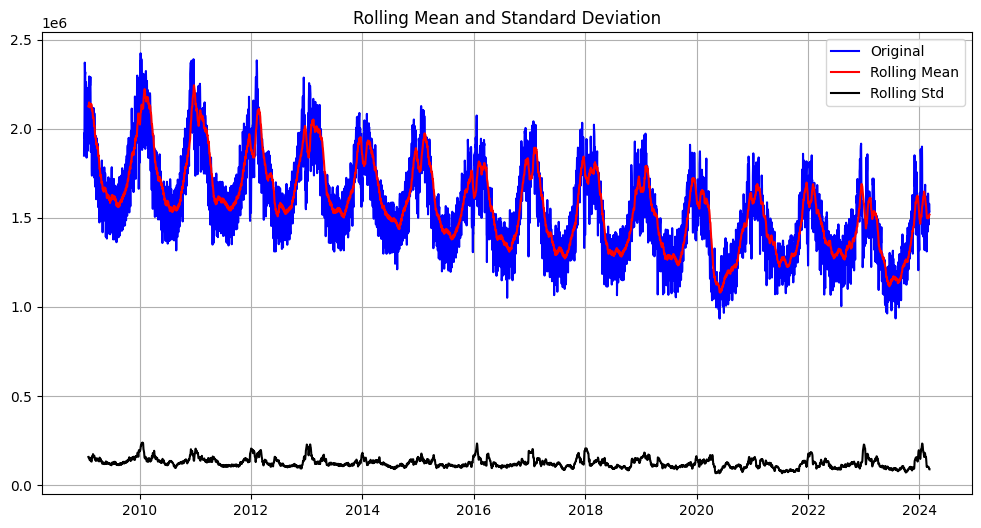

In [51]:
dftest(df_sarima["tsd"], 30)

Test Statistic         -1.780233e+01
p-value                 3.214151e-30
Lags Used               3.300000e+01
Observations Used       5.510000e+03
Critical Value (1%)    -3.431537e+00
Critical Value (5%)    -2.862065e+00
Critical Value (10%)   -2.567049e+00
dtype: float64


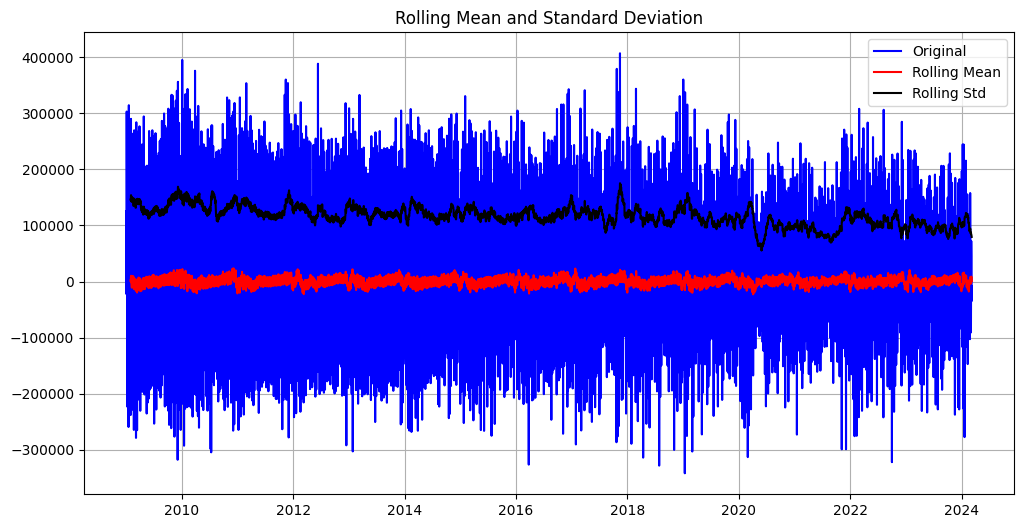

In [53]:
dftest(df_sarima["difference_day"].dropna(), 30)

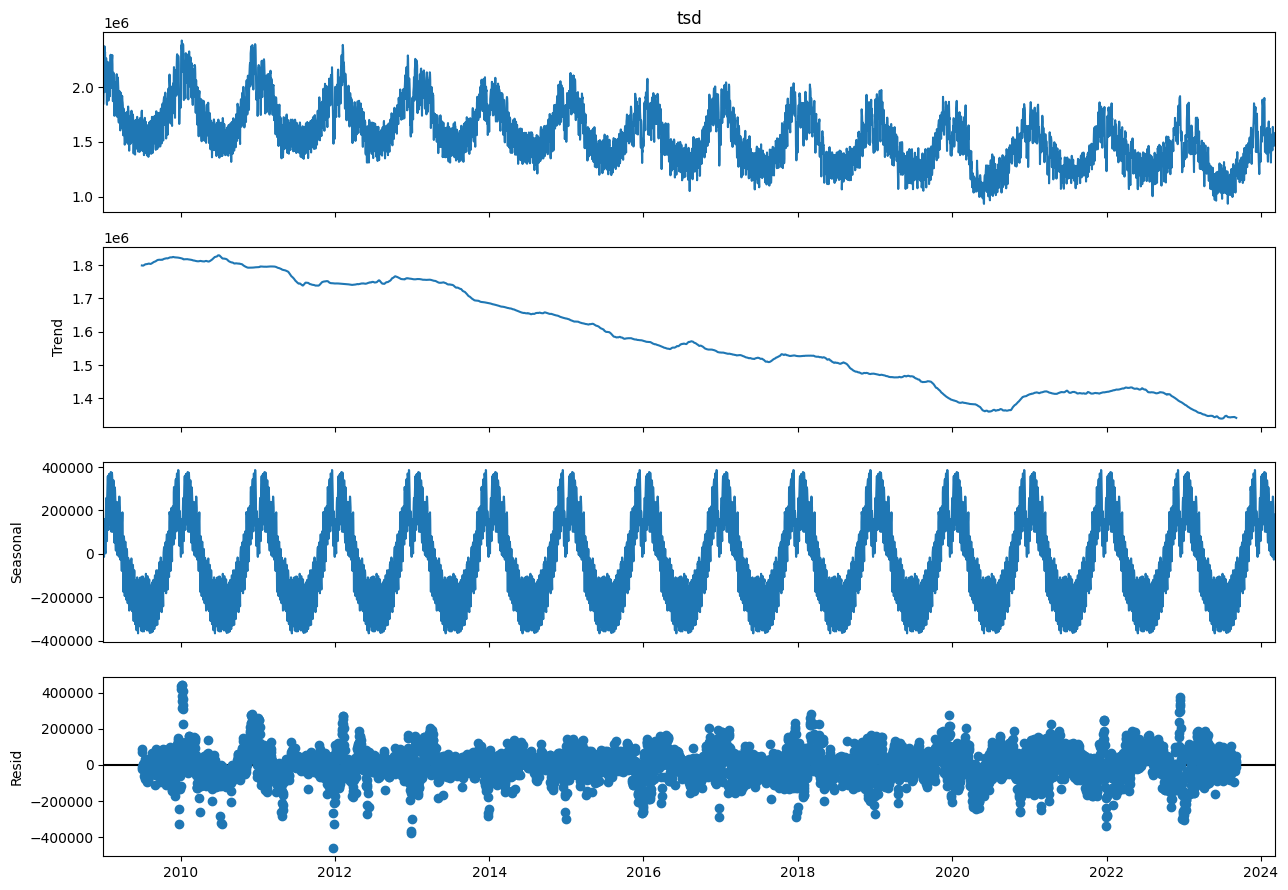

In [54]:
decompose = sm.seasonal_decompose(df_sarima["tsd"].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches((13, 9))
fig.tight_layout()

Test Statistic            -5.336604
p-value                    0.000005
Lags Used                 33.000000
Observations Used       5511.000000
Critical Value (1%)       -3.431537
Critical Value (5%)       -2.862065
Critical Value (10%)      -2.567049
dtype: float64


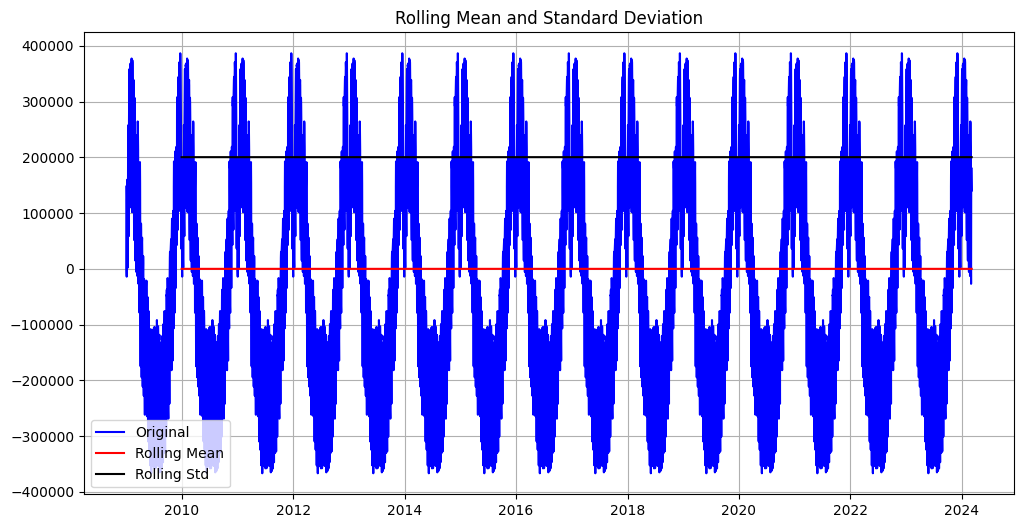

In [55]:
dftest(decompose.seasonal, 364)

Test Statistic         -8.050626e+00
p-value                 1.746016e-12
Lags Used               2.600000e+01
Observations Used       5.154000e+03
Critical Value (1%)    -3.431619e+00
Critical Value (5%)    -2.862101e+00
Critical Value (10%)   -2.567069e+00
dtype: float64


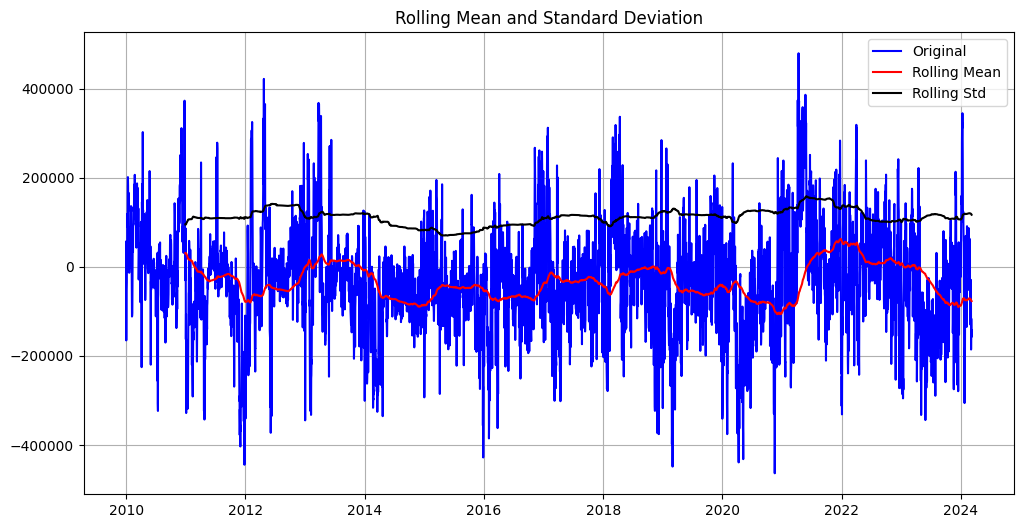

In [56]:
dftest(df_sarima["difference_year"].dropna(), 364)

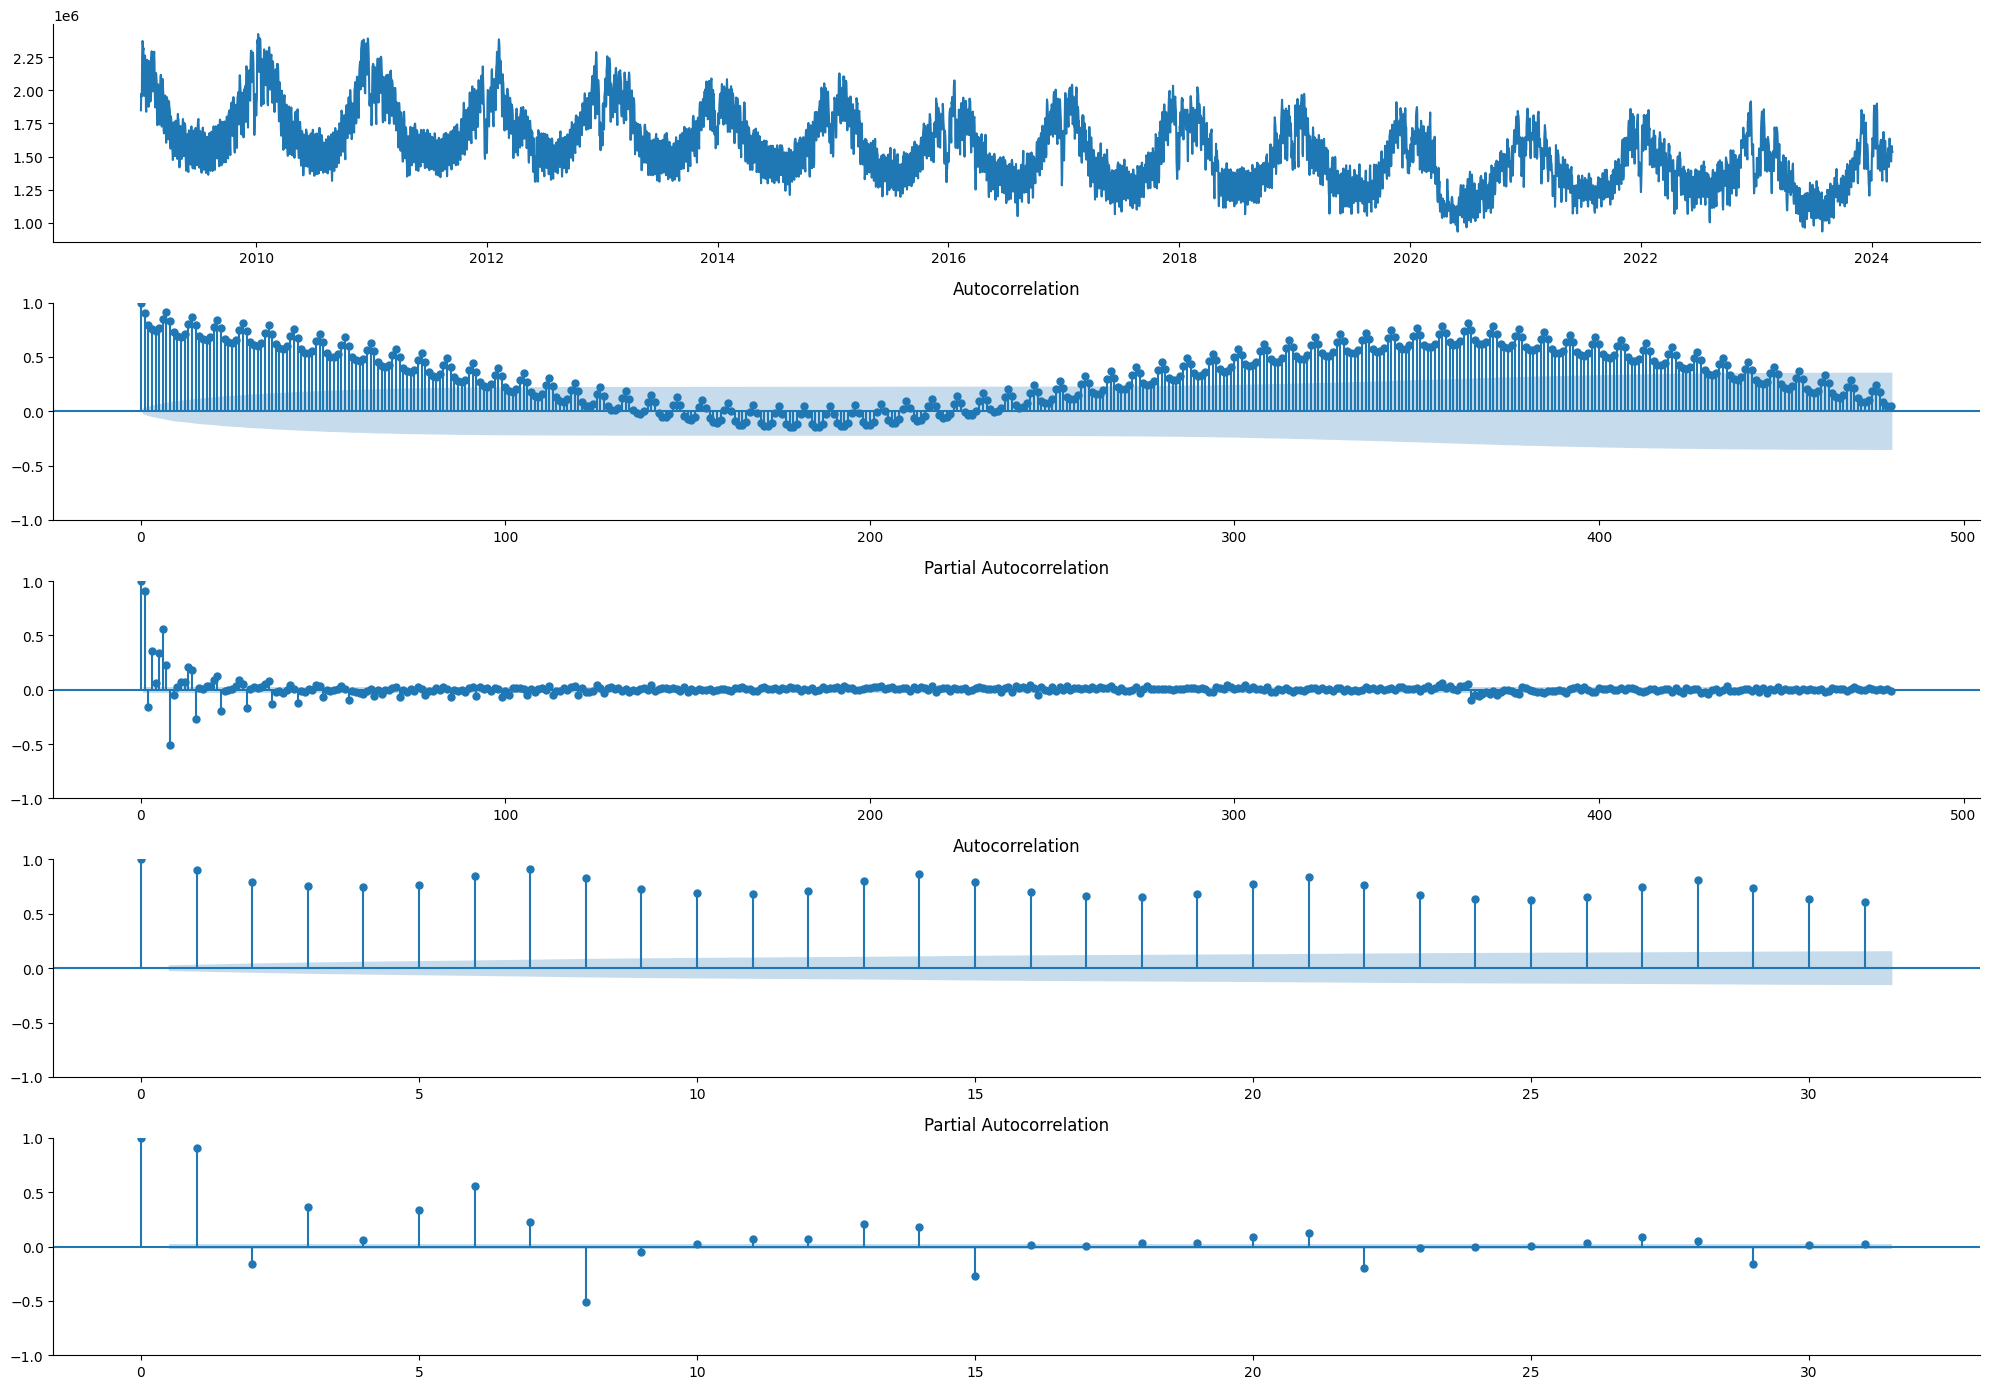

In [57]:
autocorr_plots_dual_lags(df_sarima["tsd"], lags_1=480, lags_2=31)

In [58]:
threshold_date = "01-01-2021"
train_data = df_sarima.loc[df_sarima.index < threshold_date, "tsd"]
test_data = df_sarima.loc[df_sarima.index >= threshold_date, "tsd"]

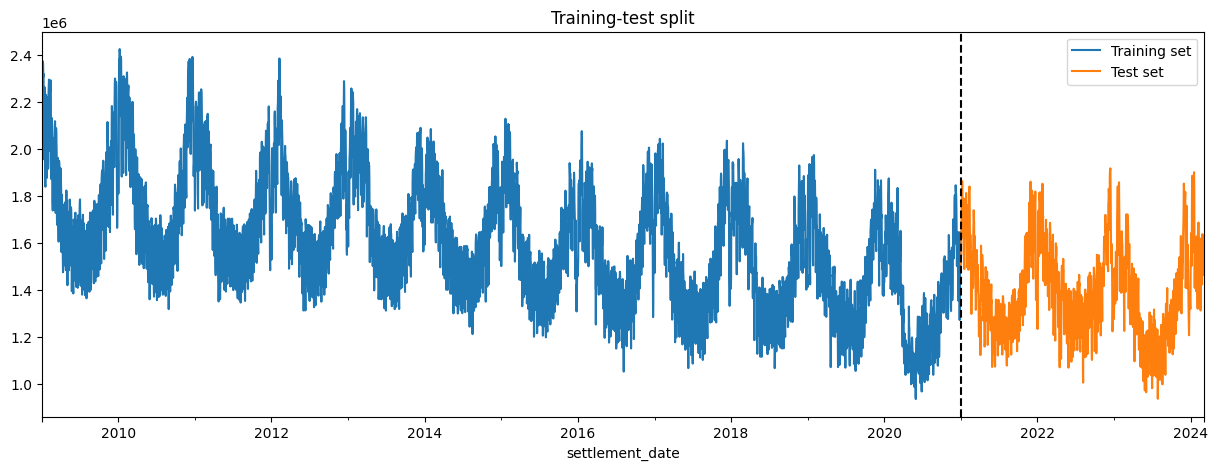

In [59]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label="Training set")
test_data.plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend();

In [60]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

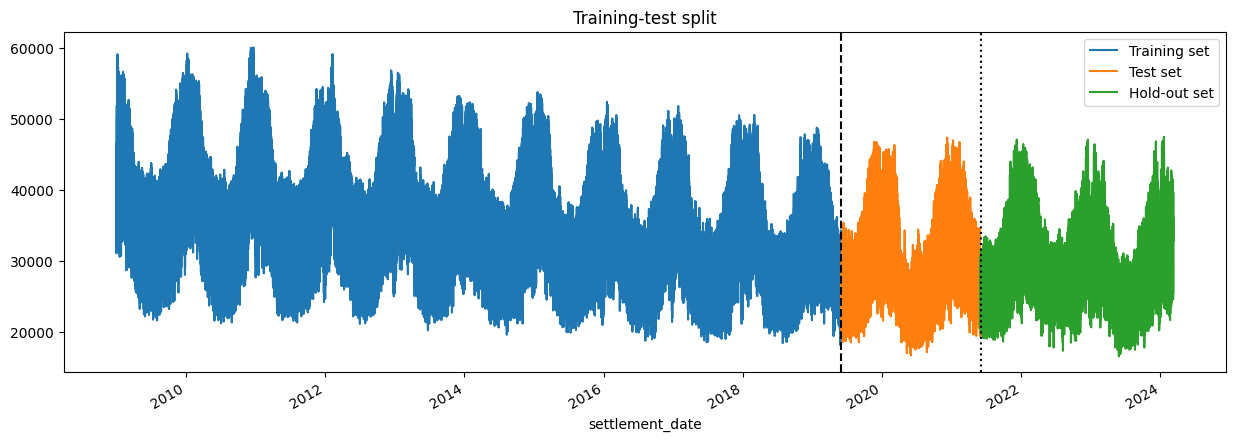

In [61]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

In [62]:
df.shape

(265410, 30)

In [63]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
#     tree_method="gpu_hist",
    random_state=43,
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
);

[0]	validation_0-rmse:7537.22500	validation_1-rmse:8060.53188
[100]	validation_0-rmse:4933.76548	validation_1-rmse:6198.28160
[200]	validation_0-rmse:3758.00700	validation_1-rmse:5226.86235
[300]	validation_0-rmse:3099.93364	validation_1-rmse:4631.24354
[400]	validation_0-rmse:2695.63980	validation_1-rmse:4262.98392
[499]	validation_0-rmse:2446.75632	validation_1-rmse:4025.51465


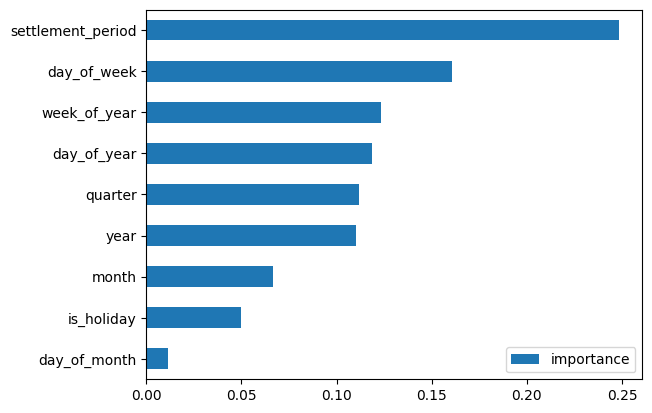

In [64]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh");

In [65]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

In [71]:
result_frame

tsd  pred_xgb_simple
settlement_date                            
2019-06-01 00:00:00  22025     21965.541016
2019-06-01 00:30:00  21501     21965.541016
2019-06-01 01:00:00  21332     21965.541016
2019-06-01 01:30:00  21405     21965.541016
2019-06-01 02:00:00  21195     21818.785156
...                    ...              ...
2021-05-31 21:30:00  27106     29313.146484
2021-05-31 22:00:00  26350     27939.597656
2021-05-31 22:30:00  25161     26108.630859
2021-05-31 23:00:00  23594     24886.683594
2021-05-31 23:30:00  22131     24043.218750

[35084 rows x 2 columns]

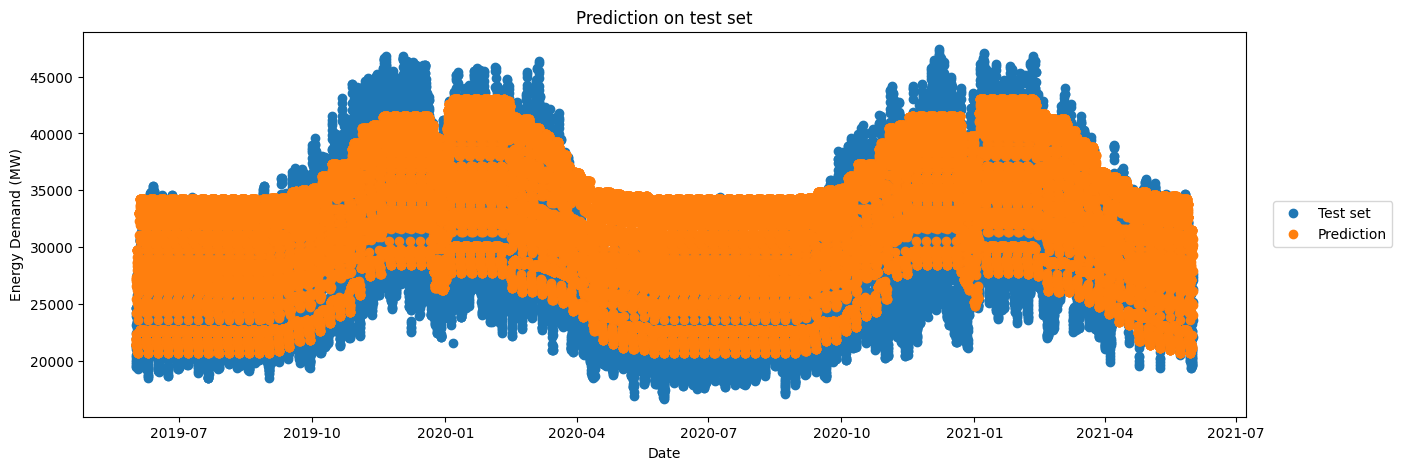

In [69]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

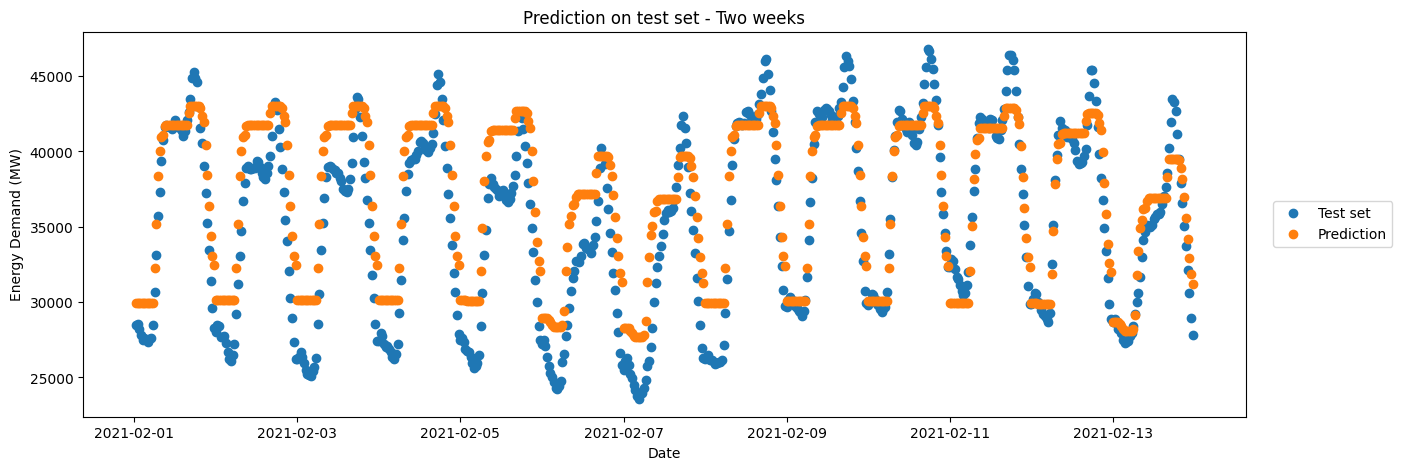

In [73]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [74]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 11.26
Root Mean Squared Error of the simple models is: 3778.96 MW


In [76]:
df.head(1)

settlement_period period_hour     nd    tsd  \
settlement_date                                                
2009-01-01                       1     0:00:00  37910  38704   

                 england_wales_demand  embedded_wind_generation  \
settlement_date                                                   
2009-01-01                      33939                        54   

                 embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                      
2009-01-01                         1403                          0   

                 embedded_solar_capacity  non_bm_stor  ...  day_of_week  \
settlement_date                                        ...                
2009-01-01                             0            0  ...            3   

                 day_of_year  quarter  month  year  week_of_year  lag1  lag2  \
settlement_date                                                                
2009-01-01                 1        1      1  2009             1   NaN   NaN   

                lag3  settlement_date  
settlement_date                        
2009-01-01       NaN       2009-01-01  

[1 rows x 30 columns]

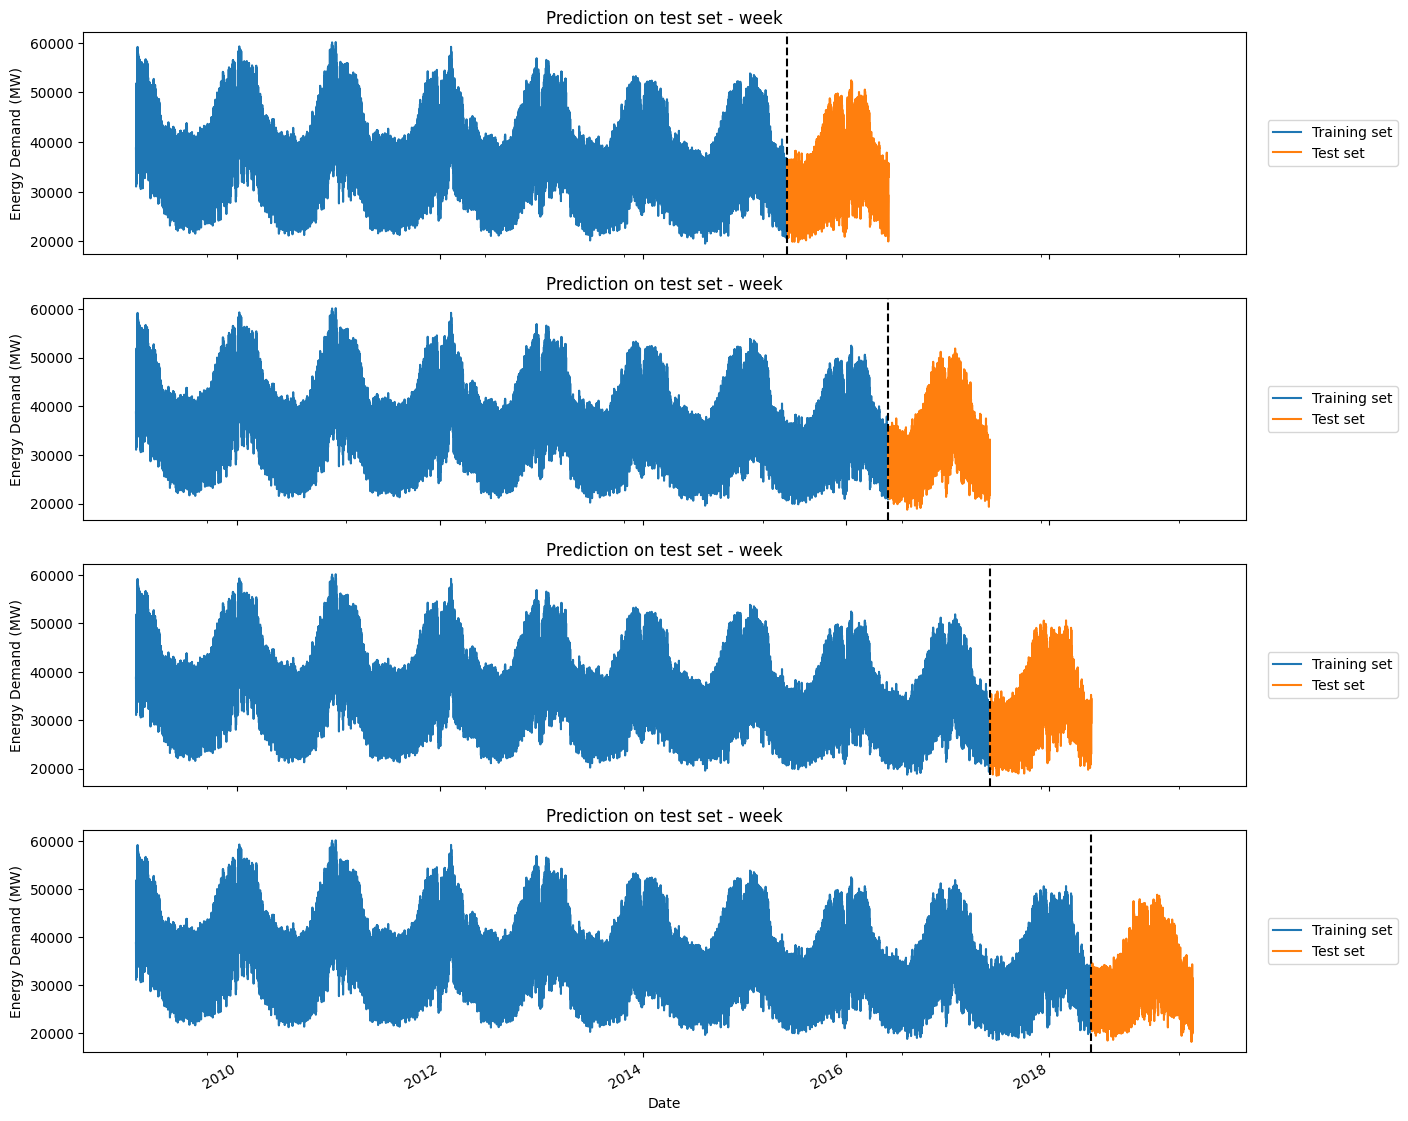

In [77]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [78]:
import warnings

def fxn():
    warnings.warn("FutureWarning", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In [79]:
%%time

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]


# Define fit parameters to allow early stopping in GridSearchCV
fit_params = {
    "early_stopping_rounds": 50,
    "eval_metric": "rmse",
    "eval_set": [[X_hold_out, y_hold_out]],
}

# Define estimator
estimator = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    learning_rate=0.01,
    tree_method="gpu_hist",
    random_state=43,
)

# Define parameters to optimiser
param_search = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
}


# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

xgb_search.fit(X_train_cv, y_train_cv, verbose=500, **fit_params);


Fitting 4 folds for each of 18 candidates, totalling 72 fits
[0]	validation_0-rmse:29289.31034
[349]	validation_0-rmse:2522.27993
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2044.026 total time=   4.9s
[0]	validation_0-rmse:29291.05300
[349]	validation_0-rmse:2574.92061
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2568.656 total time=   1.9s
[0]	validation_0-rmse:29292.15393
[349]	validation_0-rmse:2590.67875
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2788.669 total time=   1.9s
[0]	validation_0-rmse:29294.35515
[349]	validation_0-rmse:2542.09726
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2334.863 total time=   2.0s
[0]	validation_0-rmse:29289.26496
[349]	validation_0-rmse:2519.89739
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2047.250 total time=   2.2s
[0]	validation_0-rmse:29291.21369
[349]	validation_0-rmse:2579.32690
[CV 2/4] END max_depth=3, n_estimators=350, su

In [80]:
xgb_search.best_params_

{'max_depth': 5, 'n_estimators': 650, 'subsample': 0.8}

In [83]:
result_frame

tsd  pred_xgb_simple
settlement_date                            
2019-06-01 00:00:00  22025     21965.541016
2019-06-01 00:30:00  21501     21965.541016
2019-06-01 01:00:00  21332     21965.541016
2019-06-01 01:30:00  21405     21965.541016
2019-06-01 02:00:00  21195     21818.785156
...                    ...              ...
2021-05-31 21:30:00  27106     29313.146484
2021-05-31 22:00:00  26350     27939.597656
2021-05-31 22:30:00  25161     26108.630859
2021-05-31 23:00:00  23594     24886.683594
2021-05-31 23:30:00  22131     24043.218750

[35084 rows x 2 columns]

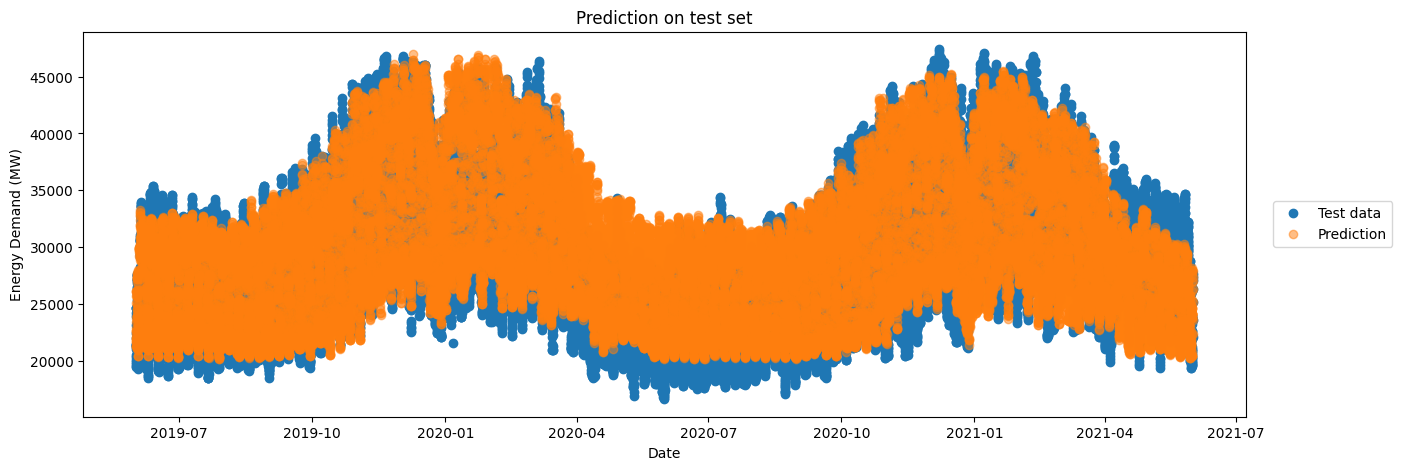

In [84]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

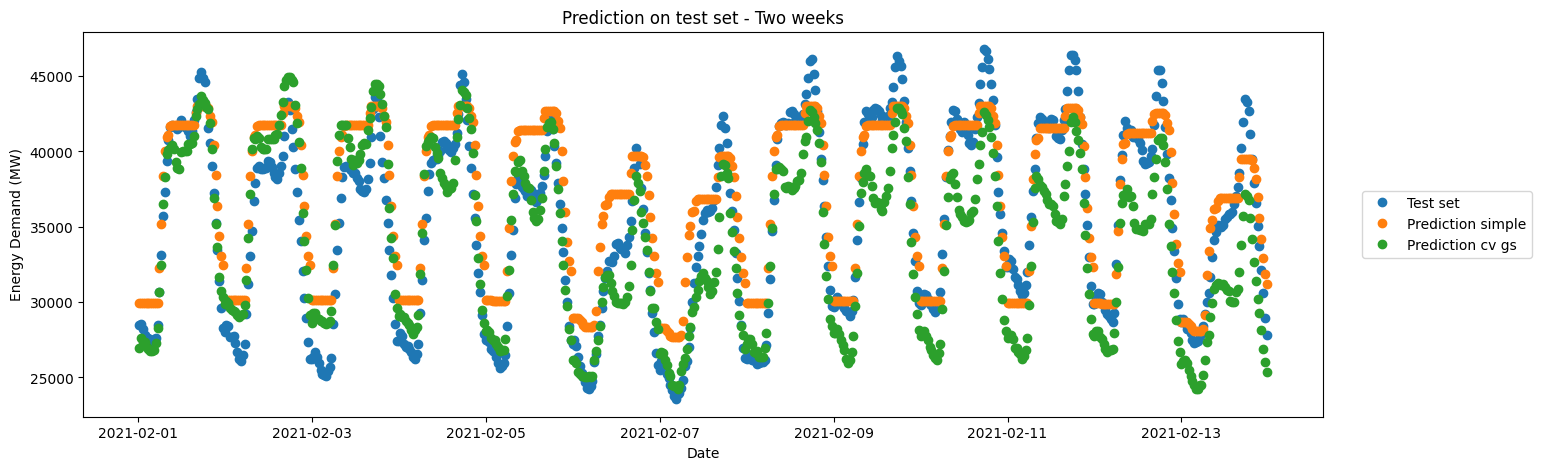

In [85]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [86]:
mape_xgboost_cv = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_cv_gs"]
)

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

Mean Absolute Percentage Error of the cross-validated model is: 7.38
Root Mean Squared Error of the cross-validated model is: 2680.56 MW


In [87]:
X_all = df[FEATURES_CV]
y_all = df[TARGET]

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1)
xgb_best.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
    verbose=100,
    early_stopping_rounds=50,
);

[0]	validation_0-rmse:33500.34308
[100]	validation_0-rmse:12506.81551
[200]	validation_0-rmse:5087.12087
[300]	validation_0-rmse:2757.96272
[400]	validation_0-rmse:2143.81863
[500]	validation_0-rmse:1960.26497
[600]	validation_0-rmse:1875.53187
[649]	validation_0-rmse:1846.83767


In [88]:
def settlement_period(df):
    """
    Determine settlement period using dataframe index date. Each settlement period
    equates to 30-minute interval.
    Settlement period equal to 0 corresponds with 00:00:00 and settlement period 48
    corresponds with 23:30:00

    Args:
        - df: time series dataframe containing dates in the future

    Returns:
        - df: time series dataframe with settlement period column
    """

    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2 + np.array(df.index.minute.to_list()) / 30 + 1
    ).astype(int)


    df["settlement_period"] = settlement_period_array

    return df


In [89]:
prediction_days = 210

future = pd.date_range(
    str(df.index.max())[0:10],
    df.index.max() + datetime.timedelta(days=prediction_days),
    freq="30min",
)

future_df = pd.DataFrame(index=future)
future_df = settlement_period(future_df)
future_df["is_future"] = True
df["is_future"] = False

# Create a dataframe containing the original data and the predict df
df_and_future = pd.concat([df, future_df])

# add features and lag
# lag values will change w.r.t original dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# add bank holidays in future dataframe
df_and_future_wprediction = df_and_future.query("is_future").copy()

df_and_future_wprediction["settlement_date"] = df_and_future_wprediction.index.date
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)

df_and_future_wprediction.tail()

settlement_period period_hour  nd  tsd  \
2024-10-03 21:30:00                 44         NaN NaN  NaN   
2024-10-03 22:00:00                 45         NaN NaN  NaN   
2024-10-03 22:30:00                 46         NaN NaN  NaN   
2024-10-03 23:00:00                 47         NaN NaN  NaN   
2024-10-03 23:30:00                 48         NaN NaN  NaN   

                     england_wales_demand  embedded_wind_generation  \
2024-10-03 21:30:00                   NaN                       NaN   
2024-10-03 22:00:00                   NaN                       NaN   
2024-10-03 22:30:00                   NaN                       NaN   
2024-10-03 23:00:00                   NaN                       NaN   
2024-10-03 23:30:00                   NaN                       NaN   

                     embedded_wind_capacity  embedded_solar_generation  \
2024-10-03 21:30:00                     NaN                        NaN   
2024-10-03 22:00:00                     NaN                        NaN   
2024-10-03 22:30:00                     NaN                        NaN   
2024-10-03 23:00:00                     NaN                        NaN   
2024-10-03 23:30:00                     NaN                        NaN   

                     embedded_solar_capacity  non_bm_stor  ...  day_of_year  \
2024-10-03 21:30:00                      NaN          NaN  ...          277   
2024-10-03 22:00:00                      NaN          NaN  ...          277   
2024-10-03 22:30:00                      NaN          NaN  ...          277   
2024-10-03 23:00:00                      NaN          NaN  ...          277   
2024-10-03 23:30:00                      NaN          NaN  ...          277   

                     quarter  month  year  week_of_year     lag1     lag2  \
2024-10-03 21:30:00        4     10  2024            40  29842.0  29387.0   
2024-10-03 22:00:00        4     10  2024            40  27696.0  27866.0   
2024-10-03 22:30:00        4     10  2024            40  26121.0  26451.0   
2024-10-03 23:00:00        4     10  2024            40  25076.0  25416.0   
2024-10-03 23:30:00        4     10  2024            40  24362.0  24558.0   

                        lag3 settlement_date  is_future  
2024-10-03 21:30:00  29017.0      2024-10-03       True  
2024-10-03 22:00:00  27336.0      2024-10-03       True  
2024-10-03 22:30:00  25776.0      2024-10-03       True  
2024-10-03 23:00:00  24882.0      2024-10-03       True  
2024-10-03 23:30:00  23630.0      2024-10-03       True  

[5 rows x 31 columns]

In [90]:
df_and_future_wprediction.head()

settlement_period period_hour  nd  tsd  \
2024-03-07 00:00:00                  1         NaN NaN  NaN   
2024-03-07 00:30:00                  2         NaN NaN  NaN   
2024-03-07 01:00:00                  3         NaN NaN  NaN   
2024-03-07 01:30:00                  4         NaN NaN  NaN   
2024-03-07 02:00:00                  5         NaN NaN  NaN   

                     england_wales_demand  embedded_wind_generation  \
2024-03-07 00:00:00                   NaN                       NaN   
2024-03-07 00:30:00                   NaN                       NaN   
2024-03-07 01:00:00                   NaN                       NaN   
2024-03-07 01:30:00                   NaN                       NaN   
2024-03-07 02:00:00                   NaN                       NaN   

                     embedded_wind_capacity  embedded_solar_generation  \
2024-03-07 00:00:00                     NaN                        NaN   
2024-03-07 00:30:00                     NaN                        NaN   
2024-03-07 01:00:00                     NaN                        NaN   
2024-03-07 01:30:00                     NaN                        NaN   
2024-03-07 02:00:00                     NaN                        NaN   

                     embedded_solar_capacity  non_bm_stor  ...  day_of_year  \
2024-03-07 00:00:00                      NaN          NaN  ...           67   
2024-03-07 00:30:00                      NaN          NaN  ...           67   
2024-03-07 01:00:00                      NaN          NaN  ...           67   
2024-03-07 01:30:00                      NaN          NaN  ...           67   
2024-03-07 02:00:00                      NaN          NaN  ...           67   

                     quarter  month  year  week_of_year     lag1     lag2  \
2024-03-07 00:00:00        1      3  2024            10  27981.0  25738.0   
2024-03-07 00:30:00        1      3  2024            10  28600.0  25856.0   
2024-03-07 01:00:00        1      3  2024            10  28374.0  25930.0   
2024-03-07 01:30:00        1      3  2024            10  27839.0  25782.0   
2024-03-07 02:00:00        1      3  2024            10  27464.0  25430.0   

                        lag3 settlement_date  is_future  
2024-03-07 00:00:00  23911.0      2024-03-07       True  
2024-03-07 00:30:00  24476.0      2024-03-07       True  
2024-03-07 01:00:00  24663.0      2024-03-07       True  
2024-03-07 01:30:00  24307.0      2024-03-07       True  
2024-03-07 02:00:00  24015.0      2024-03-07       True  

[5 rows x 31 columns]

In [91]:
df.tail()

settlement_period period_hour     nd    tsd  \
settlement_date                                                    
2024-03-07 21:30:00                 44    21:30:00  30950  31827   
2024-03-07 22:00:00                 45    22:00:00  28691  29417   
2024-03-07 22:30:00                 46    22:30:00  26993  27720   
2024-03-07 23:00:00                 47    23:00:00  25420  26322   
2024-03-07 23:30:00                 48    23:30:00  24359  25502   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2024-03-07 21:30:00                 28651                      2603   
2024-03-07 22:00:00                 26616                      2575   
2024-03-07 22:30:00                 25041                      2547   
2024-03-07 23:00:00                 23495                      2580   
2024-03-07 23:30:00                 22496                      2613   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2024-03-07 21:30:00                    6562                          0   
2024-03-07 22:00:00                    6562                          0   
2024-03-07 22:30:00                    6562                          0   
2024-03-07 23:00:00                    6562                          0   
2024-03-07 23:30:00                    6562                          0   

                     embedded_solar_capacity  non_bm_stor  ...  day_of_year  \
settlement_date                                            ...                
2024-03-07 21:30:00                    15905            0  ...           67   
2024-03-07 22:00:00                    15905            0  ...           67   
2024-03-07 22:30:00                    15905            0  ...           67   
2024-03-07 23:00:00                    15905            0  ...           67   
2024-03-07 23:30:00                    15905            0  ...           67   

                     quarter  month  year  week_of_year     lag1     lag2  \
settlement_date                                                             
2024-03-07 21:30:00        1      3  2024            10  32184.0  30652.0   
2024-03-07 22:00:00        1      3  2024            10  30330.0  29946.0   
2024-03-07 22:30:00        1      3  2024            10  28679.0  28349.0   
2024-03-07 23:00:00        1      3  2024            10  26843.0  26550.0   
2024-03-07 23:30:00        1      3  2024            10  26046.0  25398.0   

                        lag3     settlement_date  is_future  
settlement_date                                              
2024-03-07 21:30:00  29669.0 2024-03-07 21:30:00      False  
2024-03-07 22:00:00  27975.0 2024-03-07 22:00:00      False  
2024-03-07 22:30:00  26484.0 2024-03-07 22:30:00      False  
2024-03-07 23:00:00  24581.0 2024-03-07 23:00:00      False  
2024-03-07 23:30:00  24123.0 2024-03-07 23:30:00      False  

[5 rows x 31 columns]

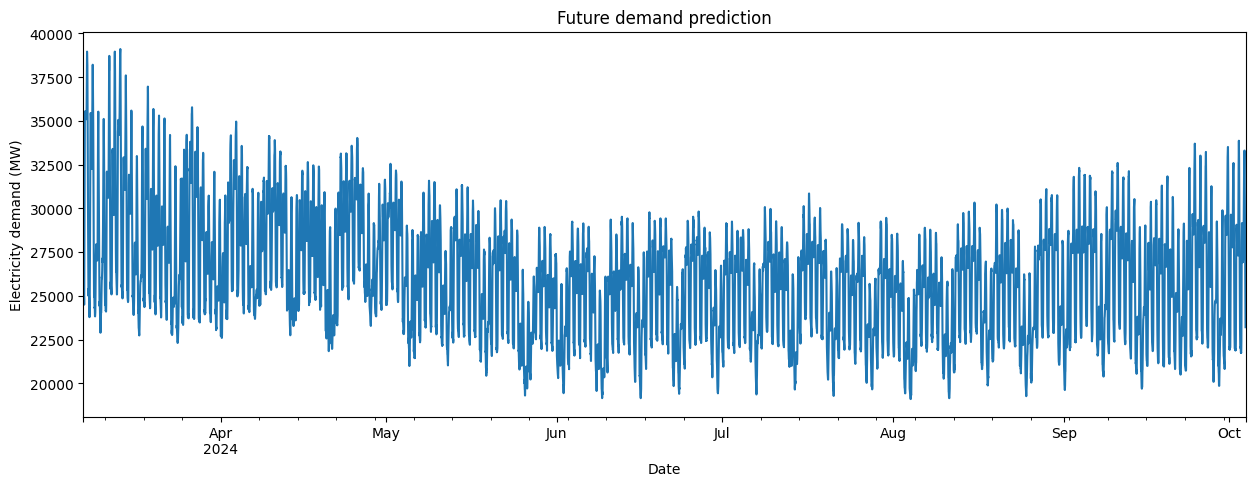

In [92]:
df_and_future_wprediction["pred_xgboost"] = xgb_best.predict(
    df_and_future_wprediction[FEATURES_CV]
)


fig, ax = plt.subplots(figsize=(15, 5))
df_and_future_wprediction["pred_xgboost"].plot(figsize=(15, 5), style="-", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

In [93]:
%%time
linear_boost = LinearBoostRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    n_estimators = 350,
    max_depth = 6,
    random_state = 43,
)

linear_boost.fit(X_train, y_train)

result_frame["pred_linear_boost"] = linear_boost.predict(X_test)

CPU times: user 56min 1s, sys: 59min 42s, total: 1h 55min 43s
Wall time: 9min 13s


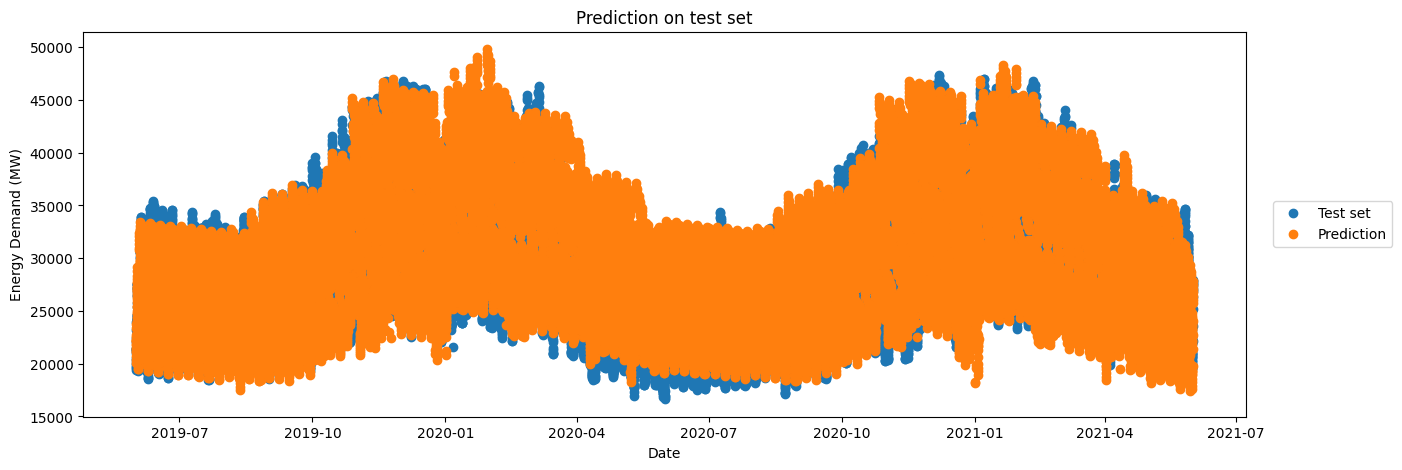

In [94]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_linear_boost"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [95]:
result_frame

tsd  pred_xgb_simple  pred_xgb_cv_gs  pred_linear_boost
settlement_date                                                               
2019-06-01 00:00:00  22025     21965.541016    23457.607422          23404.125
2019-06-01 00:30:00  21501     21965.541016    22927.326172          22154.000
2019-06-01 01:00:00  21332     21965.541016    22650.894531          21178.000
2019-06-01 01:30:00  21405     21965.541016    22646.351562          21522.375
2019-06-01 02:00:00  21195     21818.785156    22390.183594          21866.750
...                    ...              ...             ...                ...
2021-05-31 21:30:00  27106     29313.146484    27061.085938          26412.000
2021-05-31 22:00:00  26350     27939.597656    26334.238281          24058.000
2021-05-31 22:30:00  25161     26108.630859    25133.626953          22711.875
2021-05-31 23:00:00  23594     24886.683594    23556.812500          21413.125
2021-05-31 23:30:00  22131     24043.218750    22405.525391          19784.125

[35084 rows x 4 columns]

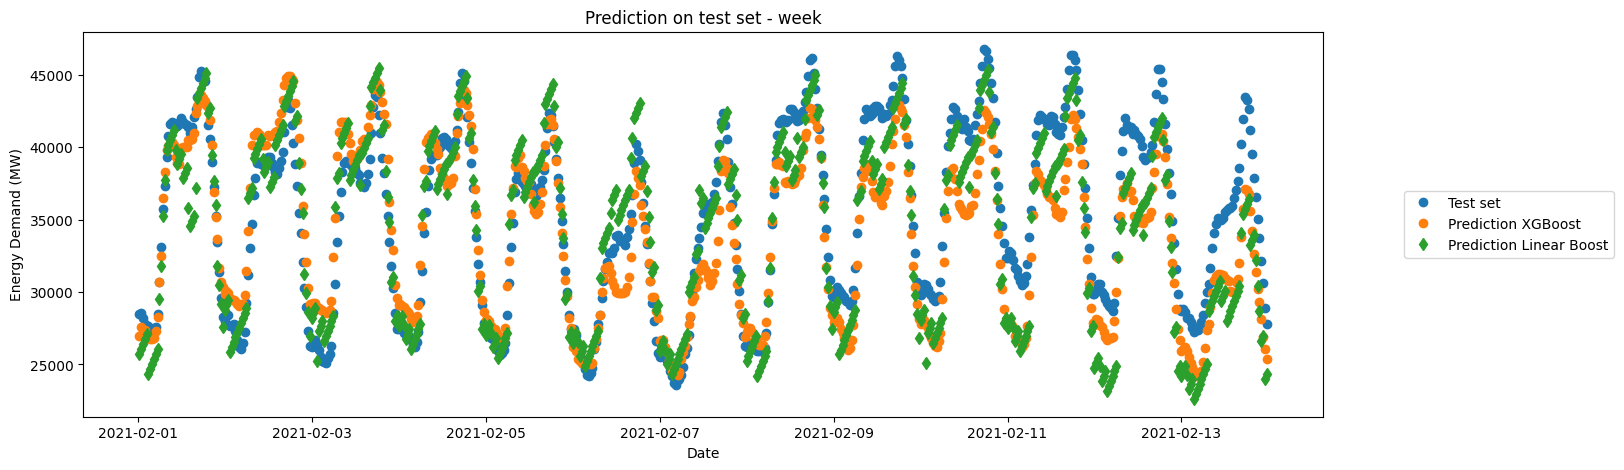

In [96]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction XGBoost",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_linear_boost"
    ],
    "d",
    label="Prediction Linear Boost",
)

ax.legend(loc="center", bbox_to_anchor=(1.15, 0.5))

ax.set_title("Prediction on test set - week")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [97]:
mape_linear_boost = mean_absolute_percentage_error(
    y_test, result_frame["pred_linear_boost"]
)
rmse_linear_boost = np.sqrt(mean_squared_error(y_test, result_frame["pred_linear_boost"]))

print(
    "Mean Absolute Percentage Error of the Linear Boosted model is: %.2f"
    % mape_linear_boost
)
print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_linear_boost
)

Mean Absolute Percentage Error of the Linear Boosted model is: 8.37
Root Mean Squared Error of the simple models is: 3004.59 MW


In [98]:
y_train.shape, y_test.shape, y_hold_out.shape, y_all.shape

((181802,), (35084,), (48524,), (265410,))

In [100]:
train_data_prophet = y_train.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
test_data_prophet = y_test.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
hold_out_data_prophet = y_hold_out.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
all_data_prophet = y_all.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

In [101]:
%%time
prophet_model = Prophet()
prophet_model.fit(train_data_prophet)

np.random.seed(43)
prophet_predict_df = prophet_model.predict(test_data_prophet)
prophet_predict_df.head()

12:57:05 - cmdstanpy - INFO - Chain [1] start processing
12:58:25 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 14.2 s, sys: 6.8 s, total: 21 s
Wall time: 1min 37s


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2019-06-01 00:00:00  30503.798133  16683.191177  23438.148330  30503.798133   
1 2019-06-01 00:30:00  30503.758866  16182.807428  22713.060960  30503.758866   
2 2019-06-01 01:00:00  30503.719599  15682.829908  22339.215505  30503.719599   
3 2019-06-01 01:30:00  30503.680332  15111.712658  21941.422647  30503.680332   
4 2019-06-01 02:00:00  30503.641064  14753.616799  21615.129398  30503.641064   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  30503.798133   -10415.234461         -10415.234461         -10415.234461   
1  30503.758866   -10999.481429         -10999.481429         -10999.481429   
2  30503.719599   -11459.951083         -11459.951083         -11459.951083   
3  30503.680332   -11880.721035         -11880.721035         -11880.721035   
4  30503.641064   -12319.769342         -12319.769342         -12319.769342   

         daily  ...      weekly  weekly_lower  weekly_upper       yearly  \
0 -5634.036855  ... -626.786270   -626.786270   -626.786270 -4154.411337   
1 -6132.517423  ... -712.688667   -712.688667   -712.688667 -4154.275338   
2 -6505.884374  ... -799.929937   -799.929937   -799.929937 -4154.136772   
3 -6838.293038  ... -888.432348   -888.432348   -888.432348 -4153.995649   
4 -7187.803672  ... -978.113691   -978.113691   -978.113691 -4153.851979   

   yearly_lower  yearly_upper  multiplicative_terms  \
0  -4154.411337  -4154.411337                   0.0   
1  -4154.275338  -4154.275338                   0.0   
2  -4154.136772  -4154.136772                   0.0   
3  -4153.995649  -4153.995649                   0.0   
4  -4153.851979  -4153.851979                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  20088.563672  
1                         0.0                         0.0  19504.277438  
2                         0.0                         0.0  19043.768516  
3                         0.0                         0.0  18622.959297  
4                         0.0                         0.0  18183.871722  

[5 rows x 22 columns]

In [105]:
prophet_predict_df

ds         trend    yhat_lower    yhat_upper  \
0     2019-06-01 00:00:00  30503.798133  16683.191177  23438.148330   
1     2019-06-01 00:30:00  30503.758866  16182.807428  22713.060960   
2     2019-06-01 01:00:00  30503.719599  15682.829908  22339.215505   
3     2019-06-01 01:30:00  30503.680332  15111.712658  21941.422647   
4     2019-06-01 02:00:00  30503.641064  14753.616799  21615.129398   
...                   ...           ...           ...           ...   
35079 2021-05-31 21:30:00  29126.185901   1995.117841  50182.212594   
35080 2021-05-31 22:00:00  29126.146634   1082.156329  49107.794565   
35081 2021-05-31 22:30:00  29126.107367   -564.346200  47256.307959   
35082 2021-05-31 23:00:00  29126.068100  -2028.417293  45537.225742   
35083 2021-05-31 23:30:00  29126.028832  -1833.408735  46490.875119   

        trend_lower   trend_upper  additive_terms  additive_terms_lower  \
0      30503.798133  30503.798133   -10415.234461         -10415.234461   
1      30503.758866  30503.758866   -10999.481429         -10999.481429   
2      30503.719599  30503.719599   -11459.951083         -11459.951083   
3      30503.680332  30503.680332   -11880.721035         -11880.721035   
4      30503.641064  30503.641064   -12319.769342         -12319.769342   
...             ...           ...             ...                   ...   
35079   4742.873530  52113.015855    -2042.722834          -2042.722834   
35080   4741.656006  52113.751710    -3659.763487          -3659.763487   
35081   4740.438482  52114.487565    -5135.658533          -5135.658533   
35082   4739.220958  52115.223420    -6375.230021          -6375.230021   
35083   4738.003434  52115.959275    -7335.412778          -7335.412778   

       additive_terms_upper        daily  ...       weekly  weekly_lower  \
0             -10415.234461 -5634.036855  ...  -626.786270   -626.786270   
1             -10999.481429 -6132.517423  ...  -712.688667   -712.688667   
2             -11459.951083 -6505.884374  ...  -799.929937   -799.929937   
3             -11880.721035 -6838.293038  ...  -888.432348   -888.432348   
4             -12319.769342 -7187.803672  ...  -978.113691   -978.113691   
...                     ...          ...  ...          ...           ...   
35079          -2042.722834   446.804823  ...  1661.870626   1661.870626   
35080          -3659.763487 -1193.429815  ...  1684.881587   1684.881587   
35081          -5135.658533 -2690.328503  ...  1705.699833   1705.699833   
35082          -6375.230021 -3948.773741  ...  1724.385825   1724.385825   
35083          -7335.412778 -4925.763876  ...  1741.003096   1741.003096   

       weekly_upper       yearly  yearly_lower  yearly_upper  \
0       -626.786270 -4154.411337  -4154.411337  -4154.411337   
1       -712.688667 -4154.275338  -4154.275338  -4154.275338   
2       -799.929937 -4154.136772  -4154.136772  -4154.136772   
3       -888.432348 -4153.995649  -4153.995649  -4153.995649   
4       -978.113691 -4153.851979  -4153.851979  -4153.851979   
...             ...          ...           ...           ...   
35079   1661.870626 -4151.398283  -4151.398283  -4151.398283   
35080   1684.881587 -4151.215259  -4151.215259  -4151.215259   
35081   1705.699833 -4151.029863  -4151.029863  -4151.029863   
35082   1724.385825 -4150.842106  -4150.842106  -4150.842106   
35083   1741.003096 -4150.651998  -4150.651998  -4150.651998   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
35079                   0.0                         0.0   
35080                   0.0                         0.0   
35081                   0.0                         0.0 

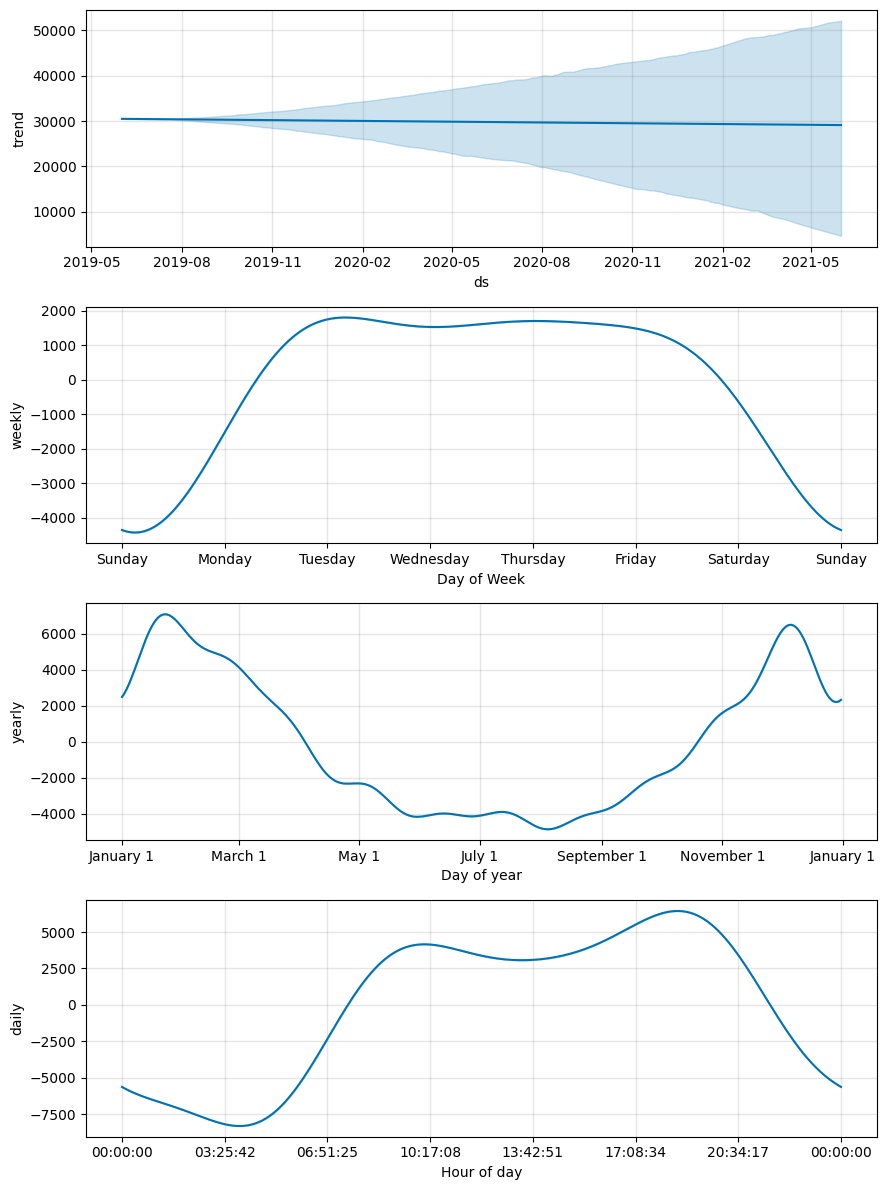

In [102]:
prophet_model.plot_components(prophet_predict_df);

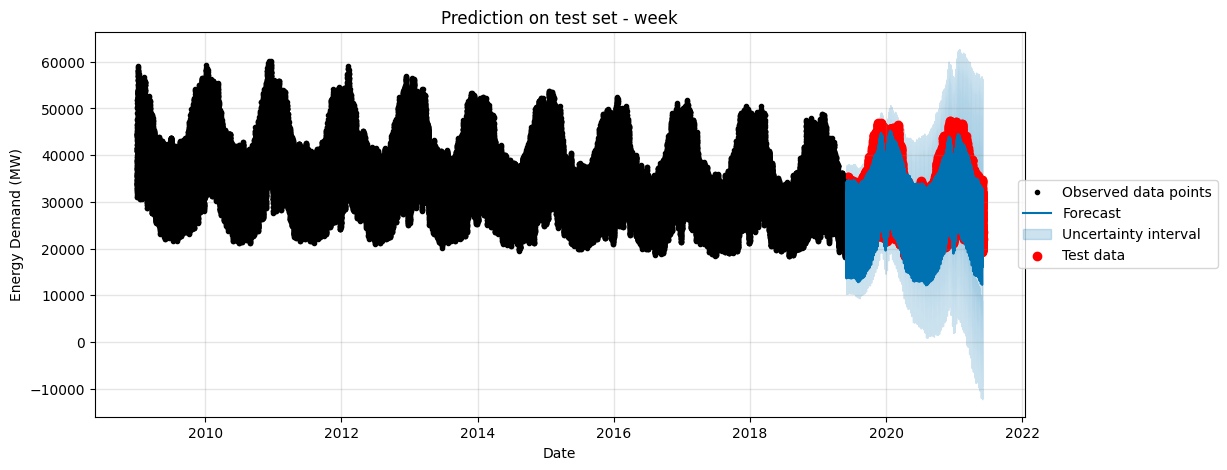

In [106]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set - week")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [126]:
threshold_date_1

'06-01-2019'

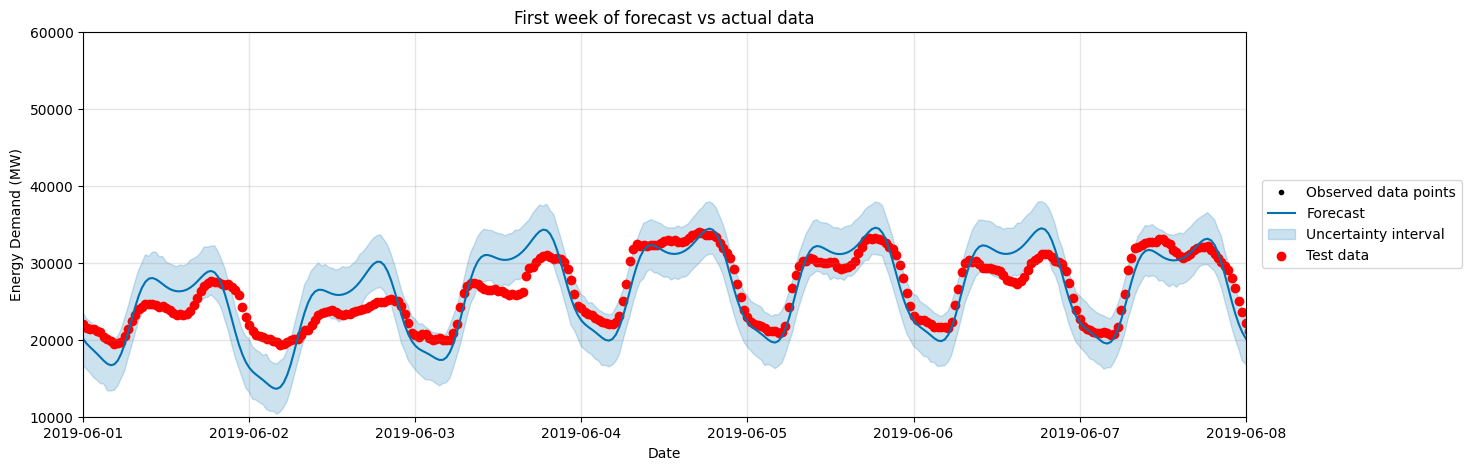

In [141]:
from datetime import datetime, timedelta

fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
date_1 = "01-06-2019"
min_date = datetime.strptime(date_1, '%d-%m-%Y')
max_date = min_date + timedelta(days = 7)
ax.set_xbound(lower=min_date, upper=max_date)
ax.set_ylim(bottom=10000, top=60000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("First week of forecast vs actual data")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [130]:
y_test.index

DatetimeIndex(['2019-06-01 00:00:00', '2019-06-01 00:30:00',
               '2019-06-01 01:00:00', '2019-06-01 01:30:00',
               '2019-06-01 02:00:00', '2019-06-01 02:30:00',
               '2019-06-01 03:00:00', '2019-06-01 03:30:00',
               '2019-06-01 04:00:00', '2019-06-01 04:30:00',
               ...
               '2021-05-31 19:00:00', '2021-05-31 19:30:00',
               '2021-05-31 20:00:00', '2021-05-31 20:30:00',
               '2021-05-31 21:00:00', '2021-05-31 21:30:00',
               '2021-05-31 22:00:00', '2021-05-31 22:30:00',
               '2021-05-31 23:00:00', '2021-05-31 23:30:00'],
              dtype='datetime64[ns]', name='settlement_date', length=35084, freq=None)

In [137]:
begin, end

('02-01-2021', '02-14-2021')

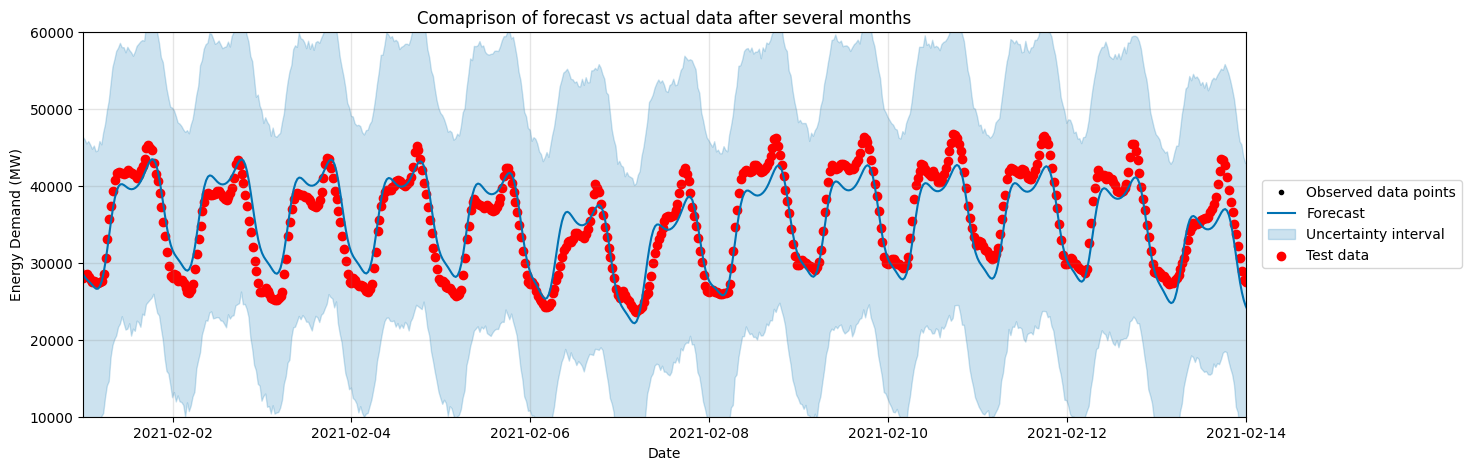

In [140]:
begin = "01-02-2021"
end = "14-02-2021"

fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")

min_date = datetime.strptime(begin, '%d-%m-%Y')
max_date = datetime.strptime(end, '%d-%m-%Y')

ax.set_xbound(lower=min_date, upper=max_date)
ax.set_ylim(bottom=10000, top=60000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Comaprison of forecast vs actual data after several months")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [142]:
%%time
mape_prophet_simple = mean_absolute_percentage_error(
    y_test, prophet_predict_df["yhat"]
)
rmse_prophet_simple = np.sqrt(mean_squared_error(y_test, prophet_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error of the simple Prophet model is: %.2f"
    % mape_prophet_simple
)
print(
    "Root Mean Squared Error of the simple Prophet models is: %.2f MW" % rmse_prophet_simple
)

Mean Absolute Percentage Error of the simple Prophet model is: 9.37
Root Mean Squared Error of the simple Prophet models is: 3259.96 MW
CPU times: user 7.8 ms, sys: 0 ns, total: 7.8 ms
Wall time: 7.22 ms


In [143]:
holiday_df = pd.DataFrame(data={"ds": holiday_dates_observed, "holiday": holiday_names_observed})
holiday_df.head()

ds              holiday
0 2009-01-01       New Year's Day
1 2009-04-10          Good Friday
2 2009-04-13        Easter Monday
3 2009-05-04              May Day
4 2009-05-25  Spring Bank Holiday

In [146]:
prophet_hol_model = Prophet(holidays=holiday_df)
prophet_hol_model.fit(train_data_prophet)

16:08:05 - cmdstanpy - INFO - Chain [1] start processing
16:09:26 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
np.random.seed(43)
prophet_hol_predict_df = prophet_hol_model.predict(test_data_prophet)

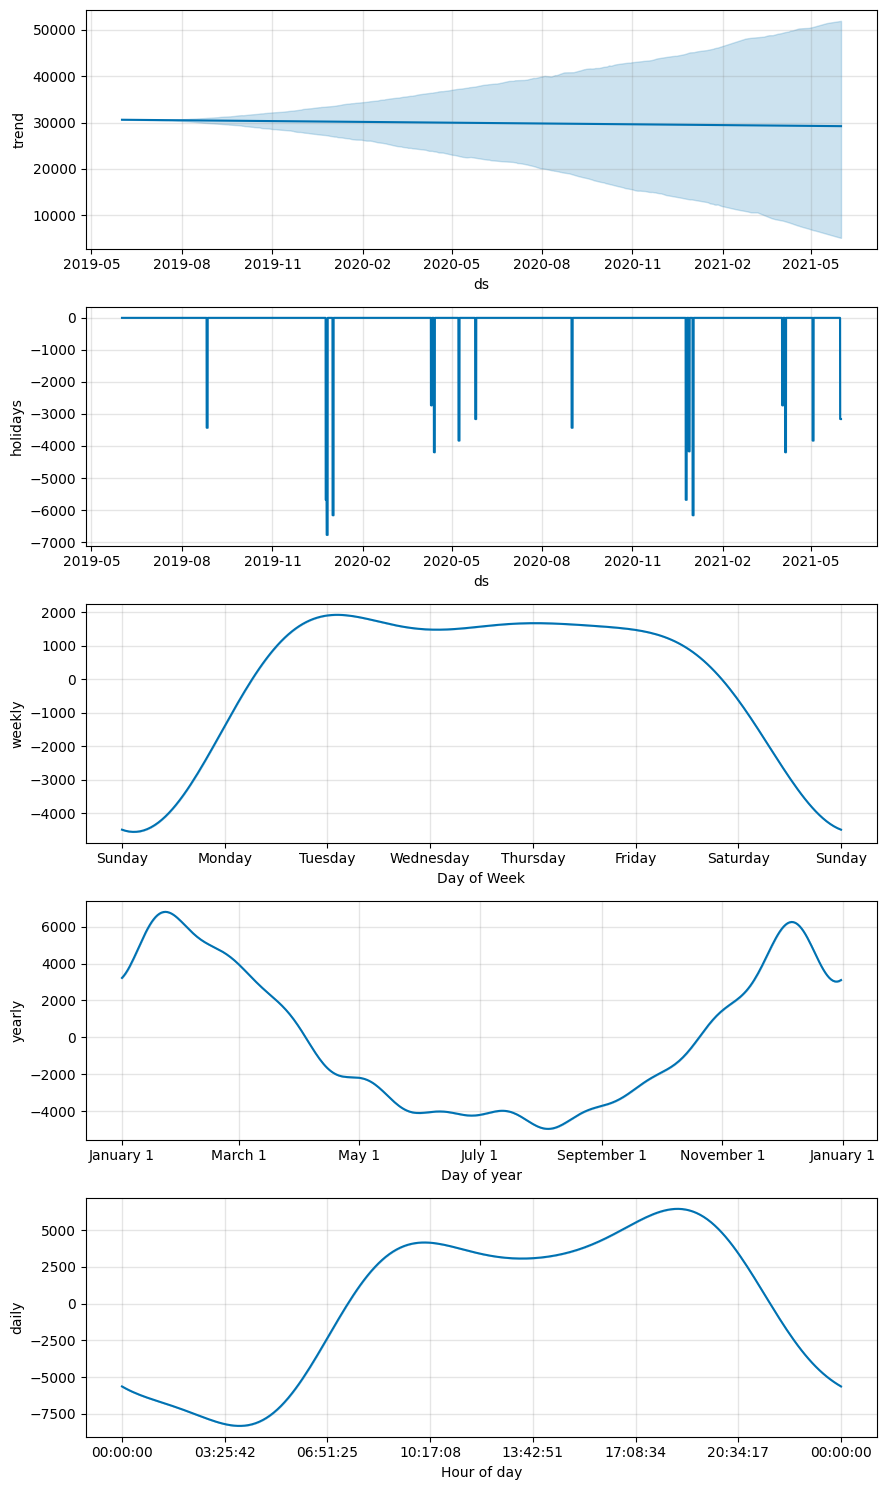

In [148]:
prophet_hol_model.plot_components(prophet_hol_predict_df);

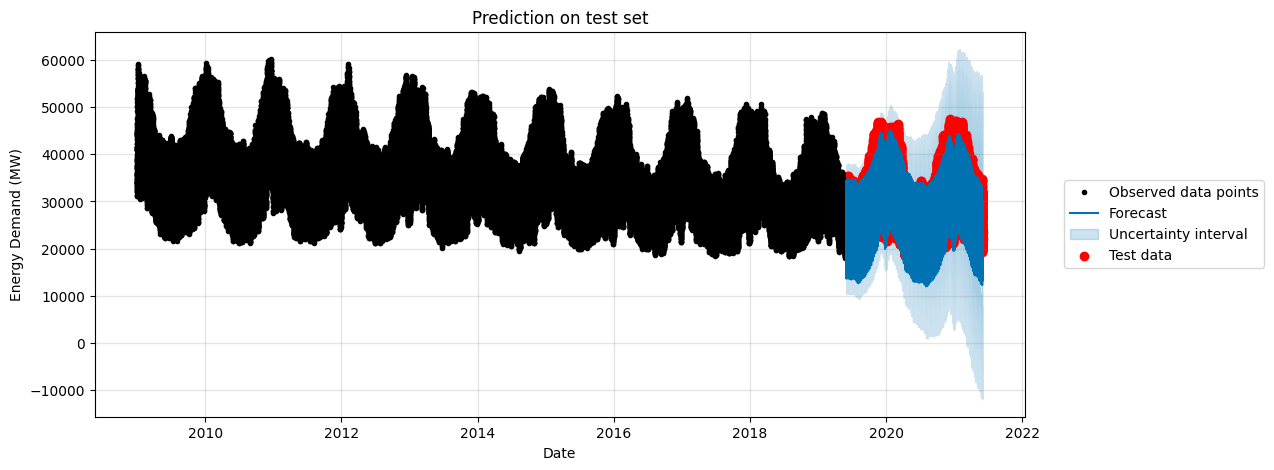

In [145]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_hol_model.plot(prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.15, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [152]:
prophet_predict_df.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2019-06-01 00:00:00  30503.798133  16683.191177  23438.148330  30503.798133   
1 2019-06-01 00:30:00  30503.758866  16182.807428  22713.060960  30503.758866   
2 2019-06-01 01:00:00  30503.719599  15682.829908  22339.215505  30503.719599   
3 2019-06-01 01:30:00  30503.680332  15111.712658  21941.422647  30503.680332   
4 2019-06-01 02:00:00  30503.641064  14753.616799  21615.129398  30503.641064   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  30503.798133   -10415.234461         -10415.234461         -10415.234461   
1  30503.758866   -10999.481429         -10999.481429         -10999.481429   
2  30503.719599   -11459.951083         -11459.951083         -11459.951083   
3  30503.680332   -11880.721035         -11880.721035         -11880.721035   
4  30503.641064   -12319.769342         -12319.769342         -12319.769342   

         daily  ...      weekly  weekly_lower  weekly_upper       yearly  \
0 -5634.036855  ... -626.786270   -626.786270   -626.786270 -4154.411337   
1 -6132.517423  ... -712.688667   -712.688667   -712.688667 -4154.275338   
2 -6505.884374  ... -799.929937   -799.929937   -799.929937 -4154.136772   
3 -6838.293038  ... -888.432348   -888.432348   -888.432348 -4153.995649   
4 -7187.803672  ... -978.113691   -978.113691   -978.113691 -4153.851979   

   yearly_lower  yearly_upper  multiplicative_terms  \
0  -4154.411337  -4154.411337                   0.0   
1  -4154.275338  -4154.275338                   0.0   
2  -4154.136772  -4154.136772                   0.0   
3  -4153.995649  -4153.995649                   0.0   
4  -4153.851979  -4153.851979                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  20088.563672  
1                         0.0                         0.0  19504.277438  
2                         0.0                         0.0  19043.768516  
3                         0.0                         0.0  18622.959297  
4                         0.0                         0.0  18183.871722  

[5 rows x 22 columns]

In [153]:
prophet_hol_predict_df.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2019-06-01 00:00:00  30602.466148  16929.170735  23489.001608  30602.466148   
1 2019-06-01 00:30:00  30602.426682  16423.750073  22765.368199  30602.426682   
2 2019-06-01 01:00:00  30602.387217  15922.150939  22386.257632  30602.387217   
3 2019-06-01 01:30:00  30602.347751  15352.483189  21984.907559  30602.347751   
4 2019-06-01 02:00:00  30602.308285  14989.040932  21652.349249  30602.308285   

    trend_upper  Boxing Day  Boxing Day_lower  Boxing Day_upper  \
0  30602.466148         0.0               0.0               0.0   
1  30602.426682         0.0               0.0               0.0   
2  30602.387217         0.0               0.0               0.0   
3  30602.347751         0.0               0.0               0.0   
4  30602.308285         0.0               0.0               0.0   

   Boxing Day (observed)  ...      weekly  weekly_lower  weekly_upper  \
0                    0.0  ... -626.973658   -626.973658   -626.973658   
1                    0.0  ... -715.283004   -715.283004   -715.283004   
2                    0.0  ... -805.073596   -805.073596   -805.073596   
3                    0.0  ... -896.263474   -896.263474   -896.263474   
4                    0.0  ... -988.765712   -988.765712   -988.765712   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0 -4105.432329  -4105.432329  -4105.432329                   0.0   
1 -4105.418424  -4105.418424  -4105.418424                   0.0   
2 -4105.402316  -4105.402316  -4105.402316                   0.0   
3 -4105.384016  -4105.384016  -4105.384016                   0.0   
4 -4105.363532  -4105.363532  -4105.363532                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  20236.174335  
1                         0.0                         0.0  19649.274827  
2                         0.0                         0.0  19186.004187  
3                         0.0                         0.0  18762.302612  
4                         0.0                         0.0  18320.208197  

[5 rows x 73 columns]

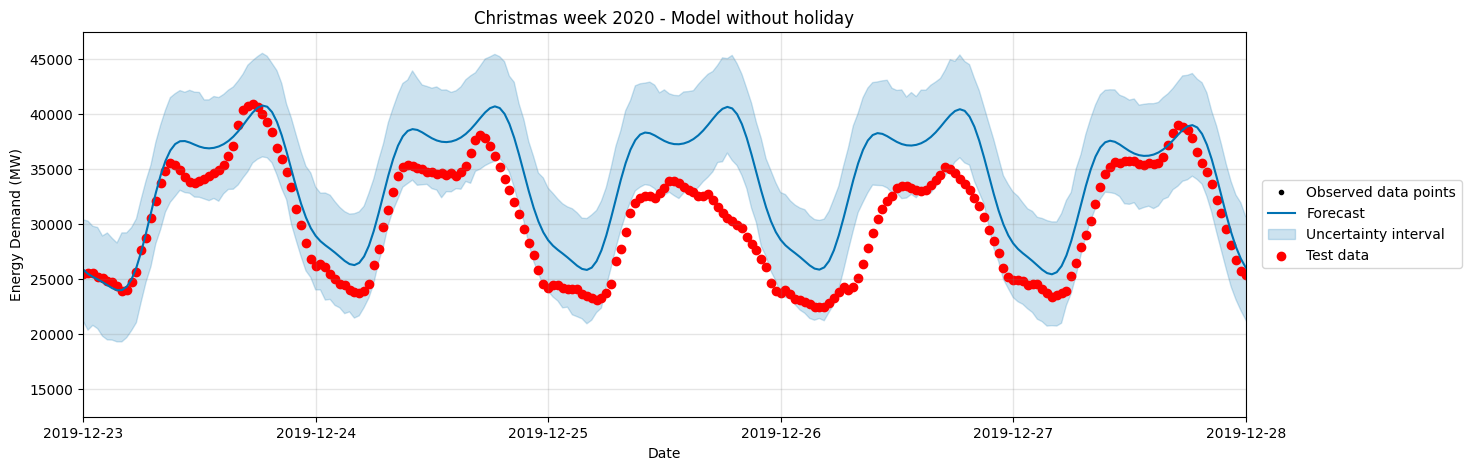

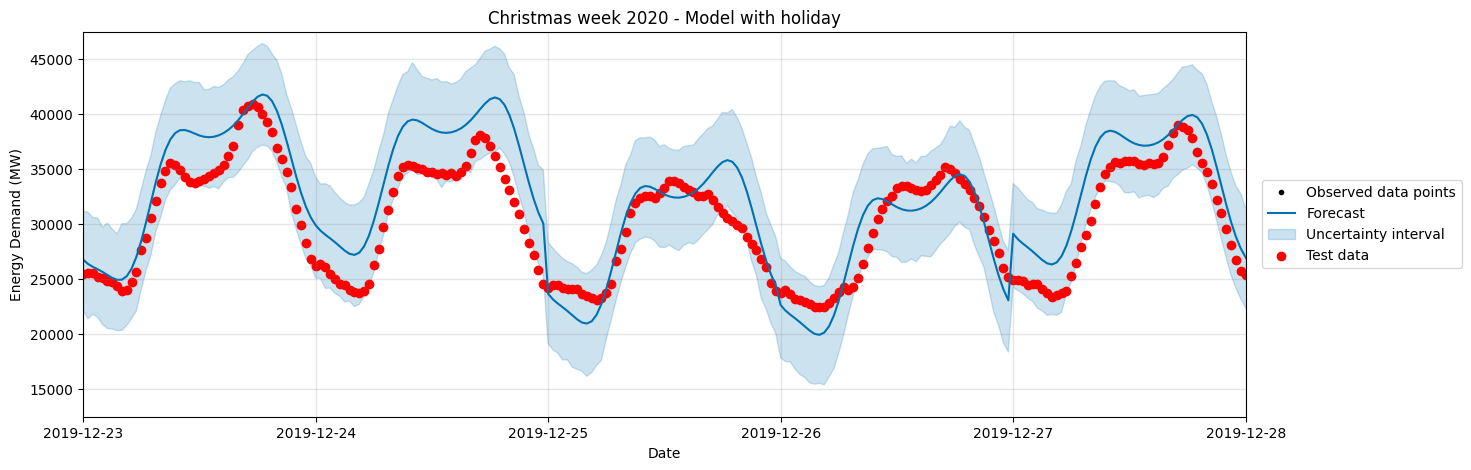

In [151]:
fig, ax = plt.subplots(figsize=(15,5))

date1="23-12-2019"
date2="28-12-2019"

min_date = datetime.strptime(date1, '%d-%m-%Y')
max_date = datetime.strptime(date2, '%d-%m-%Y')

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.set_xlim(left=min_date, right=max_date)
ax.set_ylim(bottom=12500, top=47500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Christmas week 2020 - Model without holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");


fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.set_xlim(left=min_date, right=max_date)
ax.set_ylim(bottom=12500, top=47500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Christmas week 2020 - Model with holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [155]:
threshold_date_1

'06-01-2019'

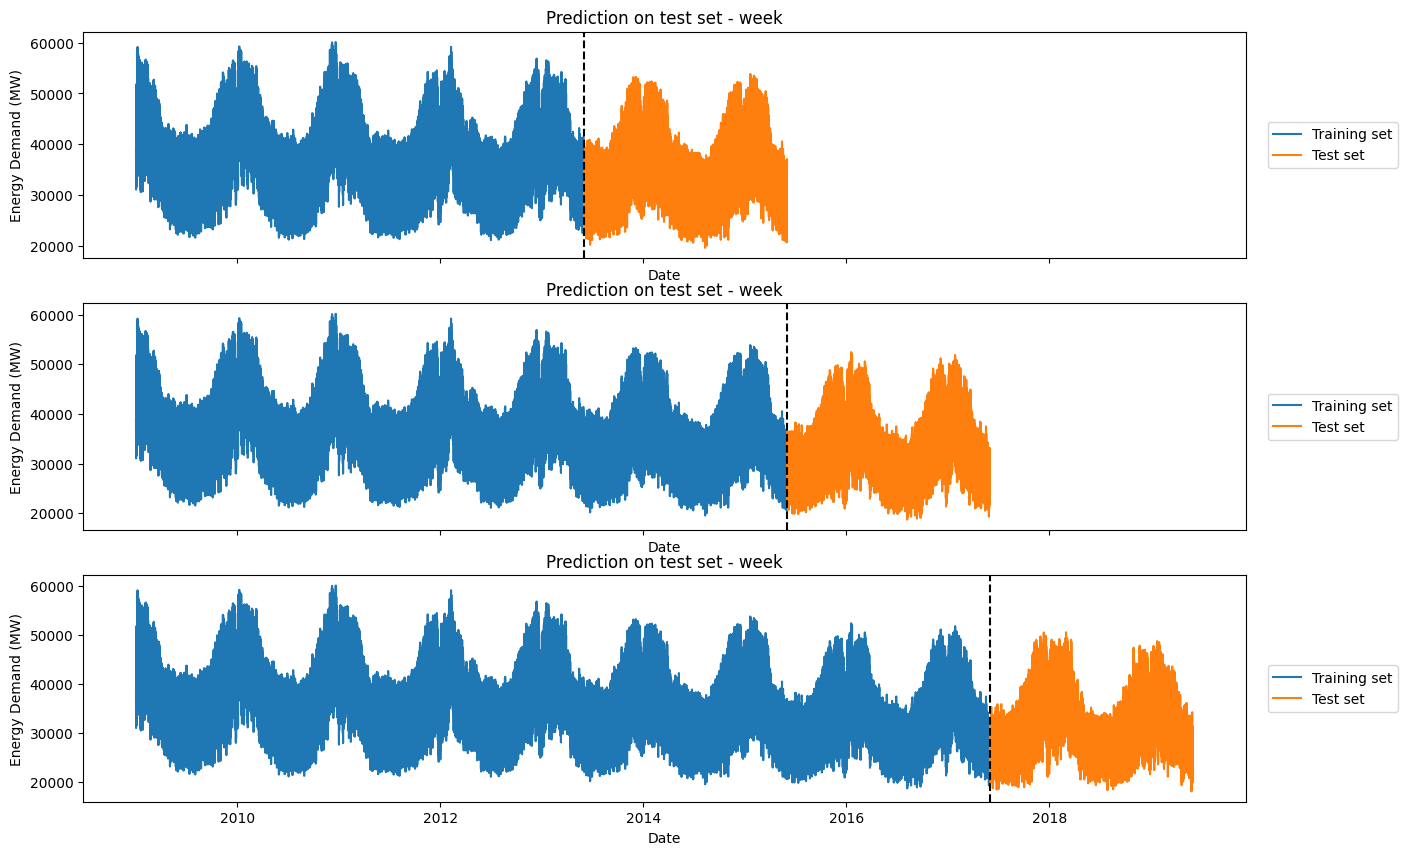

In [156]:
n_years_test = 2
tss_prophet = TimeSeriesSplit(n_splits=3, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

fold = 0
for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
    train_data = y_train.to_frame() \
                        .reset_index() \
                        .iloc[train_index] \
                        .rename(columns={"settlement_date": "ds", "tsd": "y"})

    test_data = y_train.to_frame() \
                    .reset_index() \
                    .iloc[test_index] \
                    .rename(columns={"settlement_date": "ds", "tsd": "y"})

    axes[fold].plot(train_data["ds"], train_data["y"], label="Training set")
    axes[fold].plot(test_data["ds"], test_data["y"], label="Test set")
    axes[fold].axvline(test_data["ds"].min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [157]:
%%time

# Define the parameter grid for the Prophet model
param_grid = {"changepoint_prior_scale": [0.05], "seasonality_prior_scale": [2.5, 10]}

# Create all possible combinations of the parameter grid
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

rmse_cv_gs = []

for params in all_params:
    rmse_cv = []

    for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
        train_data = y_train.to_frame() \
                            .reset_index() \
                            .iloc[train_index] \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

        test_data = y_train.to_frame() \
                            .reset_index() \
                            .iloc[test_index] \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

        model = Prophet(**params, holidays=holiday_df)
        model.fit(train_data)

        prediction = model.predict(test_data)
        mse_val = mean_squared_error(test_data["y"], prediction["yhat"])
        rmse_cv.append(np.sqrt(mse_val))

    rmse_cv_gs.append(np.mean(rmse_cv))

grid_search_results = pd.DataFrame(all_params)
grid_search_results['rmse'] = rmse_cv_gs

grid_search_results

16:22:04 - cmdstanpy - INFO - Chain [1] start processing
16:22:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
16:25:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:16 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:27:21 - cmdstanpy - INFO - Chain [1] done processing
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:28:55 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1min 14s, sys: 34.7 s, total: 1min 48s
Wall time: 7min 4s


changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.05                      2.5  2789.028930
1                     0.05                     10.0  2838.825074

In [158]:
best_params = all_params[np.argmin(rmse_cv_gs)]
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 2.5}


In [159]:
# Create Prophet using the best parameters from the grid search
prophet_best = Prophet(**best_params, holidays=holiday_df)
prophet_best.fit(train_data_prophet)

prophet_best_predict_df = prophet_best.predict(test_data_prophet)

# Compute MAPE value
mape_prophet_cv_gs = mean_absolute_percentage_error(
    y_test, prophet_best_predict_df["yhat"]
)
rmse_prophet_cv_gs = np.sqrt(
    mean_squared_error(y_test, prophet_best_predict_df["yhat"])
)
print(
    "Mean Absolute Percentage Error of the best-parameters Prophet model is: %.2f"
    % mape_prophet_cv_gs
)
print(
    "Root Mean Squared Error of the Prophet (with cross-validation) model is: %.2f MW" % rmse_prophet_cv_gs
)

16:35:52 - cmdstanpy - INFO - Chain [1] start processing
16:37:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error of the best-parameters Prophet model is: 9.35
Root Mean Squared Error of the Prophet (with cross-validation) model is: 3238.75 MW


In [161]:
# Fit a new model using all the data as training data
prophet_future_model = Prophet(**best_params, holidays=holiday_df)
prophet_future_model.fit(all_data_prophet)


16:46:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:55 - cmdstanpy - INFO - Chain [1] done processing


In [162]:
# Make predictions on future dataframe
prophet_future = prophet_future_model.make_future_dataframe(periods=210*24, freq="H", include_history=False)

In [163]:
prophet_fut_forecast = prophet_future_model.predict(prophet_future)

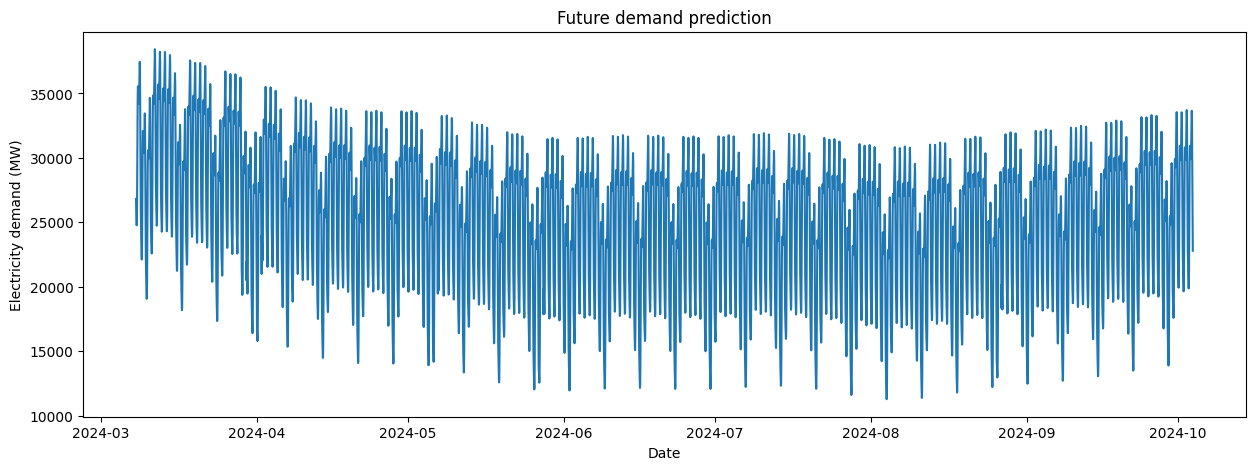

In [164]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(prophet_fut_forecast["ds"], prophet_fut_forecast["yhat"])

ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

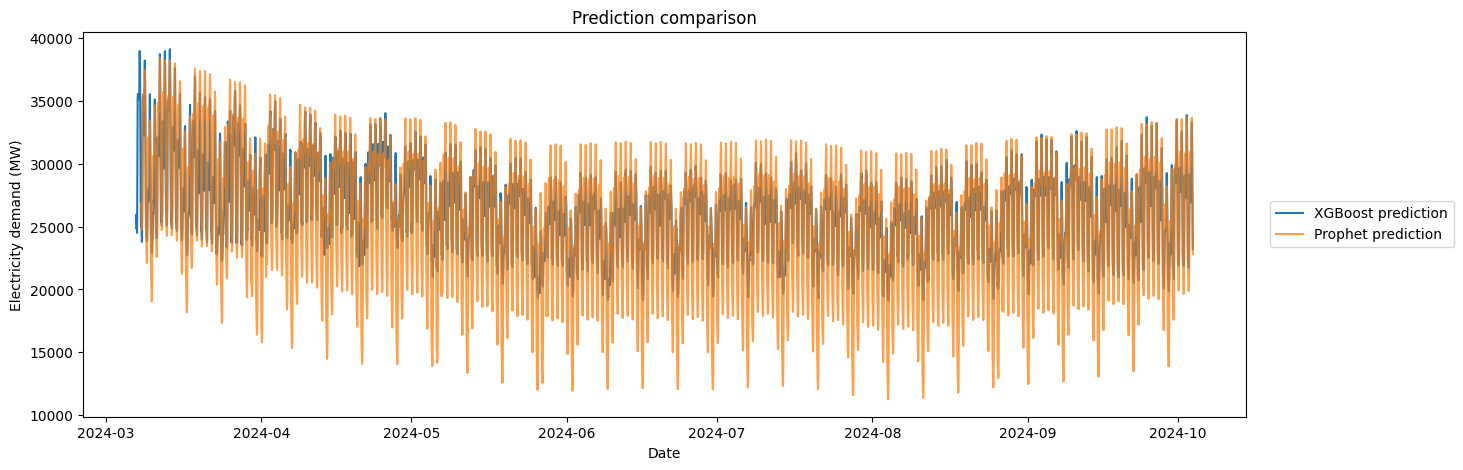

In [165]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(
        df_and_future_wprediction.index,
        df_and_future_wprediction["pred_xgboost"],
        label = "XGBoost prediction"
        )
ax.plot(
        prophet_fut_forecast["ds"],
        prophet_fut_forecast["yhat"],
        label = "Prophet prediction",
        alpha = 0.75
        )

ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Prediction comparison")

ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);

In [183]:
# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [167]:
threshold_date_1, threshold_date_2

('06-01-2019', '06-01-2021')

In [169]:
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0,1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(FEATURES))
)
y_train_keras = train_data_keras_s[:,-1]

X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(FEATURES))
)
y_test_keras = test_data_keras_s[:,-1]

In [172]:
path

'/home/rahuliyer/code/hramzan01/market/notebooks'

In [177]:
model_save_path = os.path.join(path,"simple_lstm")
model_save_path

'/home/rahuliyer/code/hramzan01/market/notebooks/simple_lstm'

In [178]:
model_save_file = os.path.join(path,"simple_lstm", "checkpoint.weights.h5")

In [179]:
folder_path = model_save_path
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")

Folder '/home/rahuliyer/code/hramzan01/market/notebooks/simple_lstm' created.


In [184]:
# Define a random seed for reproducibility
tf.random.set_seed(221)

# Create and compite neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = root_mean_squared_error
mode="min"
early_stopping = EarlyStopping(monitor=root_mean_squared_error, patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    model_save_file,
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)

Epoch 1/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1547 - val_loss: 0.0975 - learning_rate: 0.0010
Epoch 2/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1077 - val_loss: 0.0901 - learning_rate: 0.0010
Epoch 3/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0983 - val_loss: 0.0877 - learning_rate: 0.0010
Epoch 4/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0934 - val_loss: 0.0856 - learning_rate: 0.0010
Epoch 5/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0898 - val_loss: 0.0839 - learning_rate: 0.0010
Epoch 6/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0875 - val_loss: 0.0822 - learning_rate: 0.0010
Epoch 7/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0858 - val_loss: 0.0815 - learning_rate: 0.0010
Epoch 8/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0848 - val_loss: 0.0805 - learning_rate: 0.0010
Epoch 9/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0837 - val_loss: 0.0802 - learn

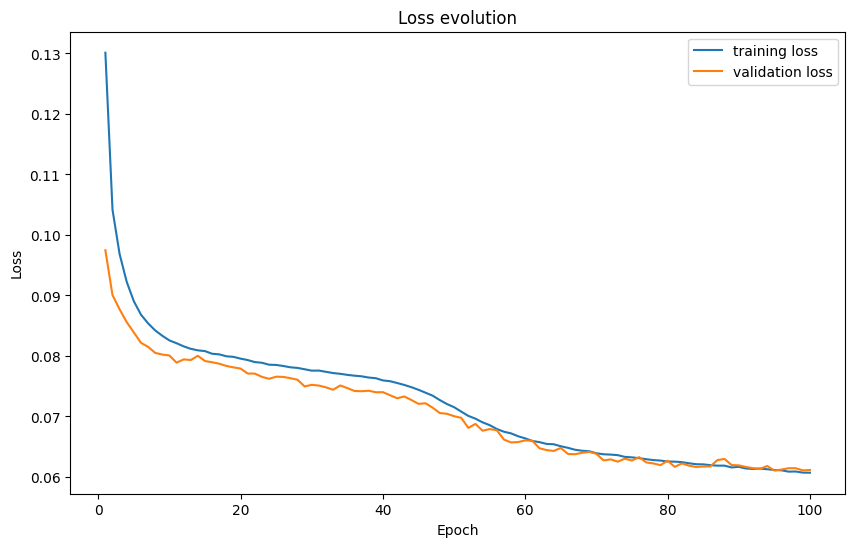

In [185]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

In [186]:
# Prediction on test set
pred_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_lstm"] = results_lstm[:,-1]

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step


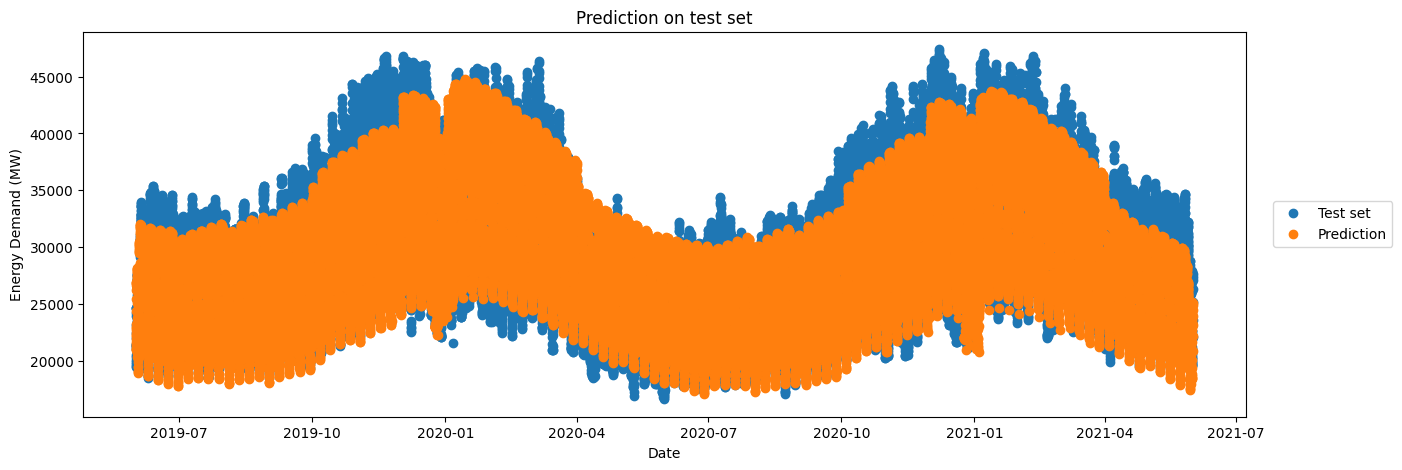

In [187]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

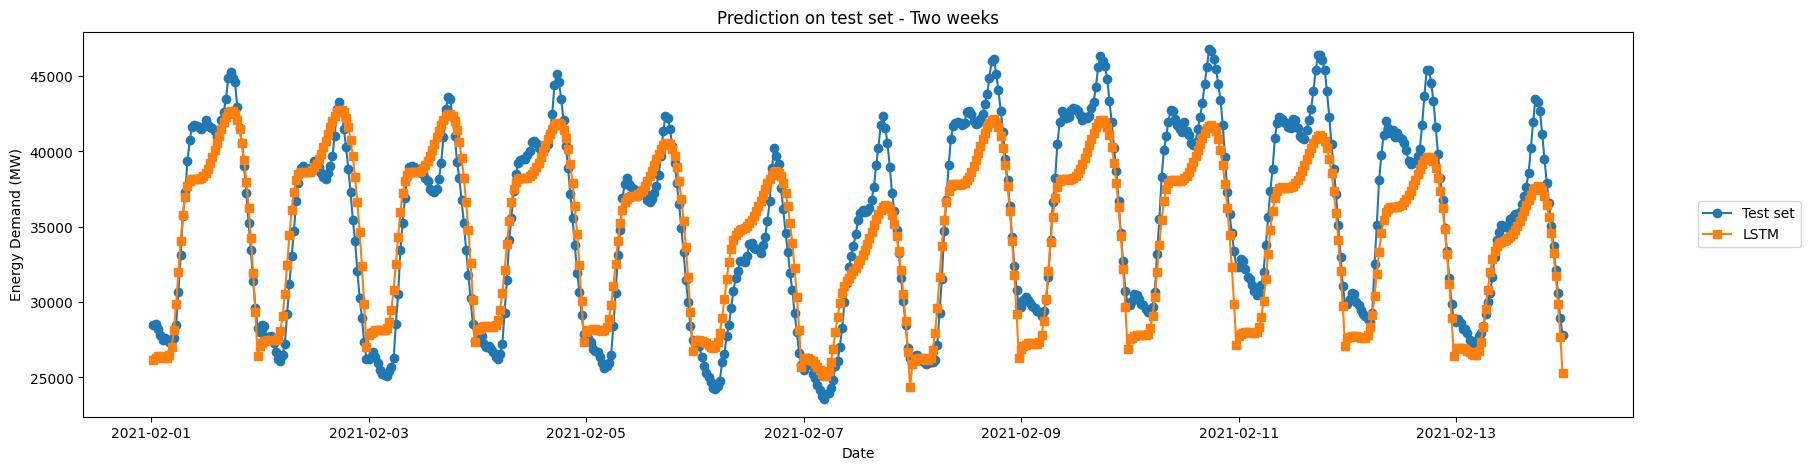

In [188]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [189]:
mape_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_lstm"]
)

rmse_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_lstm"]))

print(
    "Mean Absolute Percentage Error of the LSTM model is: %.2f" % mape_lstm
)

print(
    "Root Mean Squared Error of the LSTM model is: %.2f MW" % rmse_lstm
)

Mean Absolute Percentage Error of the LSTM model is: 7.46
Root Mean Squared Error of the LSTM model is: 2749.41 MW


: 